In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create a directory in drive
import os
work_dir = '/content/drive/MyDrive/Clothes-Project'
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)
print(f"Working directory: {work_dir}")

Working directory: /content/drive/MyDrive/Clothes-Project


In [ ]:
# GPU availability
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("Built with CUDA:", tf.test.is_built_with_cuda())

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True


In [ ]:
# Upload dataset
from google.colab import files
import zipfile

def upload_and_extract_dataset():
    print("Upload your dataset ZIP file")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"Extracting {filename}...")
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('.')
        print("Dataset extracted")

upload_and_extract_dataset()

Upload your dataset ZIP file


Saving dataset.zip to dataset.zip
Extracting dataset.zip...
Dataset extracted


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2, Xception
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import json
from pathlib import Path
from dataclasses import dataclass, asdict
from typing import List, Dict
from datetime import datetime
import random
import os
from tensorflow.nn import softmax
import cv2
import numpy as np
from PIL import Image

In [ ]:
from pathlib import Path

dataset_dir = Path("/content/drive/MyDrive/Clothes-Project/clothes")

In [ ]:
def count_images_per_class(base_dir):
    base_dir = Path(base_dir)
    class_counts = {}

    for class_dir in sorted(base_dir.iterdir()):
        if class_dir.is_dir():
            image_extensions = ('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')
            images = [f for f in class_dir.iterdir()
                     if f.is_file() and f.suffix in image_extensions]
            class_counts[class_dir.name] = len(images)

    return class_counts


dataset_counts = count_images_per_class(dataset_dir)

total_images = sum(dataset_counts.values())
print(f"\nTotal images: {total_images}")
print(f"Number of classes: {len(dataset_counts)}")
print("\nImages per class:")

for class_name, count in sorted(dataset_counts.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / total_images) * 100
    print(f"  {class_name:30s}: {count:4d} images ({percentage:5.2f}%)")


Total images: 3302
Number of classes: 9

Images per class:
  skirt                         :  429 images (12.99%)
  t-shirt                       :  408 images (12.36%)
  shirt                         :  402 images (12.17%)
  shoes                         :  400 images (12.11%)
  watches                       :  400 images (12.11%)
  pants                         :  397 images (12.02%)
  glasses                       :  357 images (10.81%)
  outwear                       :  299 images ( 9.06%)
  hat                           :  210 images ( 6.36%)


In [ ]:
import random
from PIL import Image
import numpy as np
from collections import Counter
from pathlib import Path

def analyze_image_properties(base_dir, sample_size=200):
    base_dir = Path(base_dir)
    image_paths = []

    for class_dir in base_dir.iterdir():
        if class_dir.is_dir():
            for img_file in class_dir.iterdir():
                if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    image_paths.append(img_file)

    # Take sample before split
    sample = random.sample(image_paths, min(sample_size, len(image_paths)))

    widths, heights, formats, corrupted = [], [], [], []

    for img_path in sample:
        try:
            with Image.open(img_path) as img:
                widths.append(img.width)
                heights.append(img.height)
                formats.append(img.format)
        except:
            corrupted.append(str(img_path))

    print(f"\nAnalyzed {len(sample)} images")

    if widths:
        print("\nImage Dimensions:")
        print(f"  Width  - Min: {min(widths):4d}, Max: {max(widths):4d}, Mean: {np.mean(widths):6.1f}")
        print(f"  Height - Min: {min(heights):4d}, Max: {max(heights):4d}, Mean: {np.mean(heights):6.1f}")

        print("\nFormat Distribution:")
        format_counts = Counter(formats)
        for fmt, count in format_counts.most_common():
            print(f"  {fmt}: {count} images ({count/len(sample)*100:.1f}%)")

    if corrupted:
        print(f"\nFound {len(corrupted)} corrupted images:")
        for path in corrupted[:5]:
            print(f"  - {path}")
    else:
        print("\nNo corrupted images found")

    return widths, heights

widths, heights = analyze_image_properties(dataset_dir, sample_size=300)


Analyzed 300 images

Image Dimensions:
  Width  - Min:  202, Max: 2000, Mean:  674.7
  Height - Min:  256, Max: 2667, Mean:  867.0

Format Distribution:
  JPEG: 299 images (99.7%)
  PNG: 1 images (0.3%)

No corrupted images found


In [ ]:
import os
import shutil
import random
from pathlib import Path

def split_dataset(dataset_dir, output_dir):
    dataset_dir = Path(dataset_dir)
    output_dir = Path(output_dir)

    # Create split folders
    for split in ["train", "val", "test"]:
        (output_dir / split).mkdir(parents=True, exist_ok=True)

    for class_dir in dataset_dir.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name

            # Make class folders
            for split in ["train", "val", "test"]:
                (output_dir / split / class_name).mkdir(parents=True, exist_ok=True)

            # List images
            images = [img for img in class_dir.iterdir()
                      if img.suffix.lower() in [".jpg", ".jpeg", ".png"]]
            random.shuffle(images)

            # Step 1: 80% train_temp, 20% test
            n = len(images)
            train_set1_end = int(n * 0.8)
            train_set1 = images[:train_set1_end]
            test_set = images[train_set1_end:]

            # Step 2: 80% of train_temp = train_final
            train_set_end = int(len(train_set1) * 0.8)
            train_set = train_set1[:train_set_end]
            val_set = train_set1[train_set_end:]

            # Copy files
            for img in train_set:
                shutil.copy(img, output_dir / "train" / class_name)
            for img in val_set:
                shutil.copy(img, output_dir / "val" / class_name)
            for img in test_set:
                shutil.copy(img, output_dir / "test" / class_name)

            print(f"{class_name}: {len(train_set)} train, {len(val_set)} val, {len(test_set)} test")

dataset_dir = "/content/drive/MyDrive/Clothes-Project/clothes"
output_dir  = "/content/drive/MyDrive/Clothes-Project/clothes_split"

split_dataset(dataset_dir, output_dir)

glasses: 228 train, 57 val, 72 test
hat: 134 train, 34 val, 42 test
outwear: 191 train, 48 val, 60 test
pants: 253 train, 64 val, 80 test
shirt: 256 train, 65 val, 81 test
shoes: 256 train, 64 val, 80 test
skirt: 274 train, 69 val, 86 test
t-shirt: 260 train, 66 val, 82 test
watches: 256 train, 64 val, 80 test


In [ ]:
class ClothingClassifier:

    CATEGORIES = {
        0: 'glasses', 1: 'hat', 2: 'outwear', 3: 'pants', 4: 'shirt',
        5: 'shoes', 6: 'skirt', 7: 't-shirt', 8: 'watches'
    }

    CATEGORY_MAPPING = {
        'glasses': 'accessory', 'hat': 'accessory', 'outwear': 'outer',
        'pants': 'bottom', 'shirt': 'top', 'shoes': 'shoes',
        'skirt': 'bottom', 't-shirt': 'top', 'watches': 'accessory'
    }

    def __init__(self, model_path=None):
        self.model = None
        self.image_size = (150, 150)
        self.num_classes = 9

        if model_path and os.path.exists(model_path):
            self.load_model(model_path)
        else:
            self.model = self.build_model()

    def build_model(self, learning_rate=0.001, dropout_rate=0.4):
        # Build MobileNetV2-based classifier
        base_model = MobileNetV2(
            weights='imagenet',
            input_shape=(self.image_size[0], self.image_size[1], 3),
            include_top=False
        )
        base_model.trainable = False

        inputs = keras.Input(shape=(self.image_size[0], self.image_size[1], 3))
        x = base_model(inputs, training=False)
        x = keras.layers.GlobalAveragePooling2D()(x)
        x = keras.layers.Dense(128, activation='relu')(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        outputs = keras.layers.Dense(self.num_classes)(x)

        model = keras.Model(inputs, outputs)
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"]
        )
        return model

    def train(self, train_dir, val_dir, epochs=30, save_path='best_model.h5'):
        # Train with automatic history saving
        train_gen = ImageDataGenerator(
            preprocessing_function=preprocess_input,
            rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
            shear_range=0.1, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
        )
        train_ds = train_gen.flow_from_directory(
            train_dir, target_size=self.image_size, batch_size=32, seed=1, shuffle=True
        )

        val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
        val_ds = val_gen.flow_from_directory(
            val_dir, target_size=self.image_size, batch_size=32, seed=1, shuffle=False
        )

        print(f"\nFound {train_ds.samples} training images")
        print(f"Found {val_ds.samples} validation images")
        print(f"Classes: {list(train_ds.class_indices.keys())}\n")

        checkpoint_path = save_path.replace('.h5', '_checkpoint.h5')
        history_path = save_path.replace('.h5', '_history.pkl')

        callbacks = [
            keras.callbacks.ModelCheckpoint(save_path, monitor="val_accuracy", save_best_only=True, mode='max', verbose=1),
            keras.callbacks.ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=False, save_freq='epoch', verbose=0),
            keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
        ]

        history = self.model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

        # Save history
        try:
            with open(history_path, 'wb') as f:
                pickle.dump(history.history, f)
            print(f"\nTraining history saved to {history_path}")
        except Exception as e:
            print(f"\nWarning: Could not save history: {e}")

        # Cleanup checkpoint
        if os.path.exists(checkpoint_path):
            try:
                os.remove(checkpoint_path)
                print("Checkpoint cleaned up")
            except:
                pass

        return history

    def load_history(self, save_path='best_model.h5'):
        # Load saved training history
        history_path = save_path.replace('.h5', '_history.pkl')
        if os.path.exists(history_path):
            with open(history_path, 'rb') as f:
                return pickle.load(f)
        return None

    def evaluate(self, test_dir):
        # Evaluate model on test set
        test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
        test_ds = test_gen.flow_from_directory(test_dir, target_size=self.image_size, batch_size=32, shuffle=False)
        print(f"\nEvaluating on {test_ds.samples} test images...")
        results = self.model.evaluate(test_ds, verbose=1)
        print(f"\nTest Loss: {results[0]:.4f}")
        print(f"Test Accuracy: {results[1]:.4f}")
        return results

    def predict(self, image_path):
        # Predict single image
        img = load_img(image_path, target_size=self.image_size)
        x = img_to_array(img)
        X = preprocess_input(np.array([x]))
        pred = self.model.predict(X, verbose=0)
        pred_probs = tf.nn.softmax(pred[0]).numpy()
        top_idx = np.argmax(pred_probs)

        return {
            'category': self.CATEGORIES[top_idx],
            'simplified_category': self.CATEGORY_MAPPING[self.CATEGORIES[top_idx]],
            'confidence': float(pred_probs[top_idx]),
            'all_probabilities': {self.CATEGORIES[i]: float(pred_probs[i]) for i in range(len(pred_probs))}
        }

    def predict_batch(self, test_dir):
        # Batch predictions for confusion matrix
        test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
        test_ds = test_gen.flow_from_directory(test_dir, target_size=self.image_size, batch_size=32, shuffle=False)
        predictions = self.model.predict(test_ds, verbose=1)
        pred_classes = np.argmax(predictions, axis=1)
        return pred_classes, test_ds.classes, list(test_ds.class_indices.keys())

    def save_model(self, path='clothing_classifier.h5'):
        self.model.save(path)
        print(f"Model saved to {path}")

    def load_model(self, path):
        self.model = keras.models.load_model(path)
        print(f"Model loaded from {path}")

print("ClothingClassifier class loaded")

ClothingClassifier class loaded


In [ ]:
BASE_DIR = "/content/drive/MyDrive/Clothes-Project"

train_dir = f"{BASE_DIR}/clothes_split/train"
val_dir = f"{BASE_DIR}/clothes_split/val"
test_dir = f"{BASE_DIR}/clothes_split/test"
model_save_path = f"{BASE_DIR}/best_mobile_model.h5"

print(f"Train directory: {train_dir}")
print(f"Val directory: {val_dir}")
print(f"Test directory: {test_dir}")
print(f"Model save path: {model_save_path}")

Train directory: /content/drive/MyDrive/Clothes-Project/clothes_split/train
Val directory: /content/drive/MyDrive/Clothes-Project/clothes_split/val
Test directory: /content/drive/MyDrive/Clothes-Project/clothes_split/test
Model save path: /content/drive/MyDrive/Clothes-Project/best_mobile_model.h5


In [ ]:
tf.keras.backend.clear_session()

# Check if model already exists
if os.path.exists(model_save_path):
    print(f"Found existing model at {model_save_path}")
    print("Loading existing model...")
    classifier = ClothingClassifier(model_path=model_save_path)
    TRAINING_COMPLETED = False
else:
    print("No existing model found. Starting training...")
    classifier = ClothingClassifier(model_path=None)

    print("TRAINING CLASSIFIER")
    history = classifier.train(
        train_dir=train_dir,
        val_dir=val_dir,
        epochs=30,
        save_path=model_save_path
    )

    best_val_acc = max(history.history['val_accuracy'])
    print(f"\nTraining complete! Best validation accuracy: {best_val_acc:.4f}")
    TRAINING_COMPLETED = True

No existing model found. Starting training...


/tmp/ipython-input-1075643879.py:26: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
TRAINING CLASSIFIER
Found 2108 images belonging to 9 classes.
Found 531 images belonging to 9 classes.

Found 2108 training images
Found 531 validation images
Classes: ['glasses', 'hat', 'outwear', 'pants', 'shirt', 'shoes', 'skirt', 't-shirt', 'watches']



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.4759 - loss: 1.7038 
Epoch 1: val_accuracy improved from -inf to 0.90019, saving model to /content/drive/MyDrive/Clothes-Project/best_mobile_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 1688s 25s/step - accuracy: 0.4785 - loss: 1.6942 - val_accuracy: 0.9002 - val_loss: 0.3208 - learning_rate: 0.0010
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.8309 - loss: 0.4849
Epoch 2: val_accuracy improved from 0.90019 to 0.90772, saving model to /content/drive/MyDrive/Clothes-Project/best_mobile_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 548ms/step - accuracy: 0.8310 - loss: 0.4848 - val_accuracy: 0.9077 - val_loss: 0.2575 - learning_rate: 0.0010
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8612 - loss: 0.4097
Epoch 3: val_accuracy improved from 0.90772 to 0.92655, saving model to /content/drive/MyDrive/Clothes-Project/best_mobile_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 532ms/step - accuracy: 0.8613 - loss: 0.4097 - val_accuracy: 0.9266 - val_loss: 0.2238 - learning_rate: 0.0010
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.8769 - loss: 0.3502
Epoch 4: val_accuracy did not improve from 0.92655


66/66 ━━━━━━━━━━━━━━━━━━━━ 37s 561ms/step - accuracy: 0.8770 - loss: 0.3499 - val_accuracy: 0.9153 - val_loss: 0.2183 - learning_rate: 0.0010
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.8983 - loss: 0.3036
Epoch 5: val_accuracy improved from 0.92655 to 0.93974, saving model to /content/drive/MyDrive/Clothes-Project/best_mobile_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 534ms/step - accuracy: 0.8982 - loss: 0.3038 - val_accuracy: 0.9397 - val_loss: 0.1990 - learning_rate: 0.0010
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8890 - loss: 0.3190
Epoch 6: val_accuracy did not improve from 0.93974


66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 524ms/step - accuracy: 0.8892 - loss: 0.3185 - val_accuracy: 0.9266 - val_loss: 0.1906 - learning_rate: 0.0010
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9006 - loss: 0.2731
Epoch 7: val_accuracy did not improve from 0.93974


66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 534ms/step - accuracy: 0.9006 - loss: 0.2731 - val_accuracy: 0.9284 - val_loss: 0.1853 - learning_rate: 0.0010
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9207 - loss: 0.2564
Epoch 8: val_accuracy did not improve from 0.93974


66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 525ms/step - accuracy: 0.9207 - loss: 0.2562 - val_accuracy: 0.9303 - val_loss: 0.2003 - learning_rate: 0.0010
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9207 - loss: 0.2349
Epoch 9: val_accuracy did not improve from 0.93974


66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 534ms/step - accuracy: 0.9206 - loss: 0.2351 - val_accuracy: 0.9247 - val_loss: 0.1866 - learning_rate: 0.0010
Epoch 10/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9281 - loss: 0.2230
Epoch 10: val_accuracy did not improve from 0.93974



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 524ms/step - accuracy: 0.9281 - loss: 0.2230 - val_accuracy: 0.9322 - val_loss: 0.1964 - learning_rate: 0.0010
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.

Training history saved to /content/drive/MyDrive/Clothes-Project/best_mobile_model_history.pkl
Checkpoint cleaned up

Training complete! Best validation accuracy: 0.9397


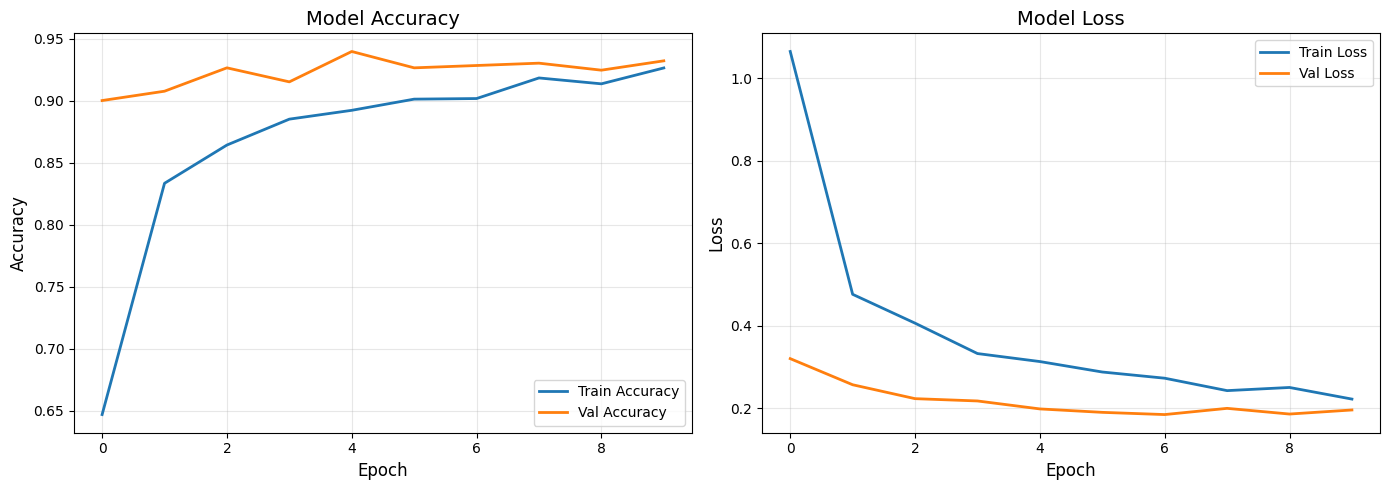

Training plots saved


In [ ]:
history_dict = classifier.load_history(model_save_path)

if history_dict:
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_dict['accuracy'], label='Train Accuracy', linewidth=2)
    plt.plot(history_dict['val_accuracy'], label='Val Accuracy', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=10)
    plt.title('Model Accuracy', fontsize=14)
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history_dict['loss'], label='Train Loss', linewidth=2)
    plt.plot(history_dict['val_loss'], label='Val Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.title('Model Loss', fontsize=14)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{BASE_DIR}/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Training plots saved")
else:
    print("No training history found")

In [ ]:
test_results = classifier.evaluate(test_dir)

Found 663 images belonging to 9 classes.

Evaluating on 663 test images...
21/21 ━━━━━━━━━━━━━━━━━━━━ 433s 22s/step - accuracy: 0.9303 - loss: 0.2346

Test Loss: 0.2109
Test Accuracy: 0.9382


DETAILED PERFORMANCE METRICS
Found 663 images belonging to 9 classes.
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 665ms/step

Classification Report:
              precision    recall  f1-score   support

     glasses       0.99      0.99      0.99        72
         hat       0.92      0.81      0.86        42
     outwear       0.82      0.90      0.86        60
       pants       1.00      0.95      0.97        80
       shirt       0.82      0.85      0.84        81
       shoes       0.98      0.99      0.98        80
       skirt       0.94      0.95      0.95        86
     t-shirt       0.96      0.94      0.95        82
     watches       1.00      1.00      1.00        80

    accuracy                           0.94       663
   macro avg       0.94      0.93      0.93       663
weighted avg       0.94      0.94      0.94       663



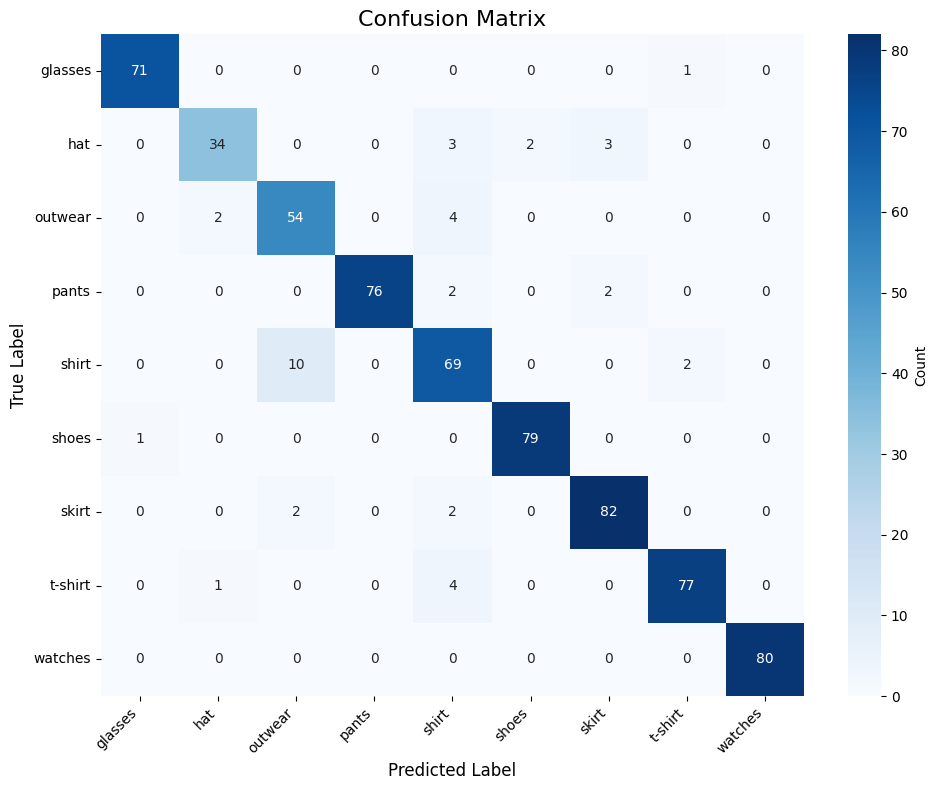


Confusion matrix saved


In [ ]:
print("DETAILED PERFORMANCE METRICS")
pred_classes, true_classes, class_labels = classifier.predict_batch(test_dir)

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{BASE_DIR}/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConfusion matrix saved")

In [ ]:
from tensorflow.keras.models import load_model

model_path = "/content/drive/MyDrive/Clothes-Project/best_mobile_model.h5"
classifier = load_model(model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


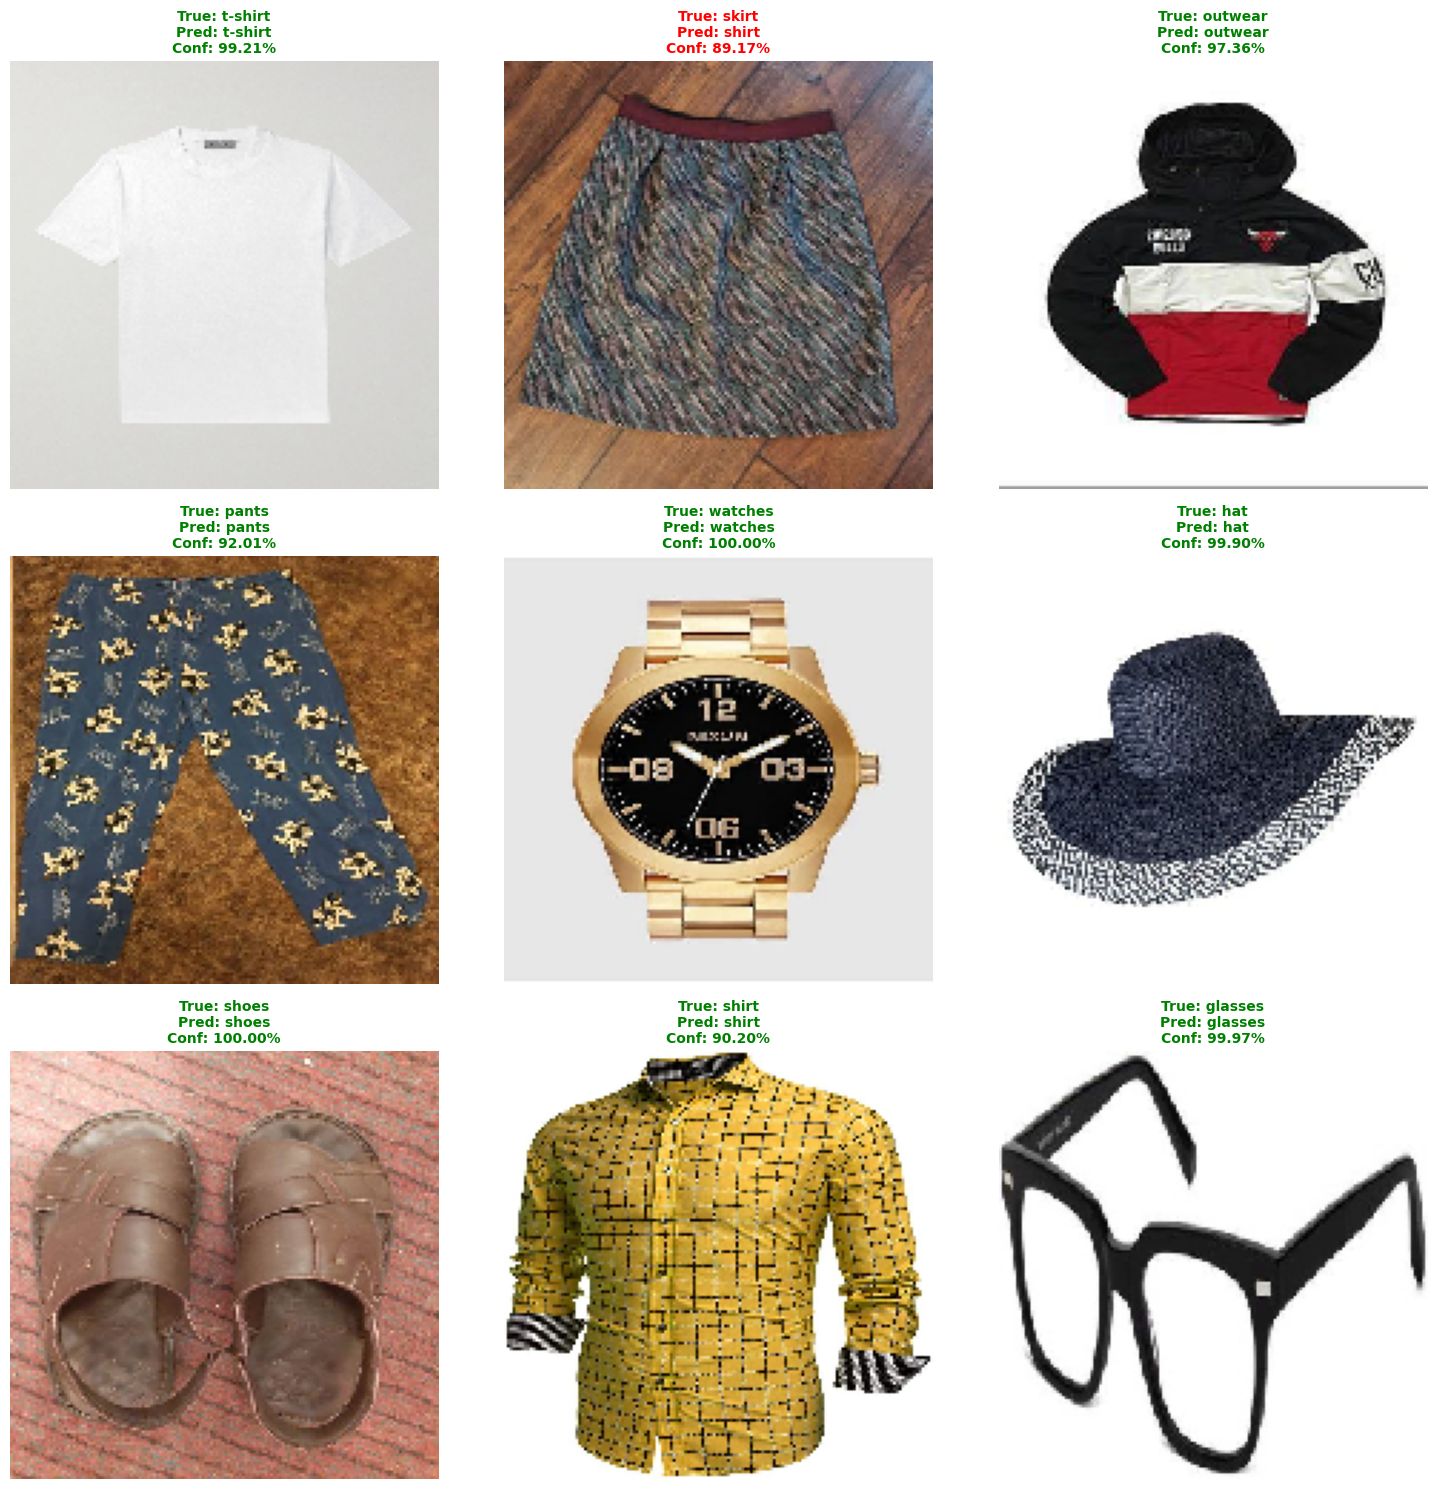

In [ ]:
def visualize_predictions(test_dir, num_samples=9):
    CLASS_NAMES = ['glasses', 'hat', 'outwear', 'pants', 'shirt', 'shoes', 'skirt', 't-shirt', 'watches']

    test_path = Path(test_dir)
    sample_images = []

    for class_dir in test_path.iterdir():
        if class_dir.is_dir():
            images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.jpeg')) + list(class_dir.glob('*.png'))
            if images:
                sample_images.append(random.choice(images))

    sample_images = random.sample(sample_images, min(num_samples, len(sample_images)))

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()

    for idx, img_path in enumerate(sample_images):
        img = load_img(img_path, target_size=(150, 150))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Get raw predictions
        raw_preds = classifier.predict(img_array)[0]

        # Convert logits → probabilities
        preds = softmax(raw_preds).numpy()

        pred_label = CLASS_NAMES[np.argmax(preds)]
        confidence = np.max(preds)

        true_label = img_path.parent.name
        color = 'green' if true_label == pred_label else 'red'

        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(
            f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2%}",
            fontsize=10, color=color, weight='bold'
        )

    plt.tight_layout()
    plt.savefig('/content/sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_predictions(test_dir, num_samples=9)

In [ ]:
@dataclass
class WardrobeItem:
    # Wardrobe items class
    id: str
    image_path: str
    category: str
    simplified_category: str
    confidence: float
    embedding: np.ndarray = None
    added_date: str = None

    def to_dict(self):
        data = asdict(self)
        if self.embedding is not None:
            data['embedding'] = self.embedding.tolist()
        return data

    @classmethod
    def from_dict(cls, data):
        if data.get('embedding') is not None:
            data['embedding'] = np.array(data['embedding'])
        return cls(**data)


class AIOutfitGenerator:
    # Generate outfit recommendations using visual similarity

    def __init__(self):
        self.embedding_model = self._build_embedding_model()
        self.image_size = (150, 150)

    def _build_embedding_model(self):
        # Build embedding model for visual similarity
        base_model = MobileNetV2(
            weights='imagenet',
            input_shape=(150, 150, 3),
            include_top=False
        )
        base_model.trainable = False

        inputs = keras.Input(shape=(150, 150, 3))
        base = base_model(inputs, training=False)
        vector = keras.layers.GlobalAveragePooling2D()(base)

        model = keras.Model(inputs, vector)
        return model

    def get_embedding(self, image_path):
        # Get normalized embedding for an image
        img = load_img(image_path, target_size=self.image_size)
        x = img_to_array(img)
        X = preprocess_input(np.array([x]))
        embedding = self.embedding_model.predict(X, verbose=0)[0]
        embedding = embedding / (np.linalg.norm(embedding) + 1e-8)
        return embedding

    def compute_embeddings(self, wardrobe: List[WardrobeItem]):
        # Compute embeddings for all items
        for item in wardrobe:
            if item.embedding is None:
                item.embedding = self.get_embedding(item.image_path)
        return wardrobe

    def visual_similarity(self, item1: WardrobeItem, item2: WardrobeItem) -> float:
        # Calculate visual similarity between two items
        if item1.embedding is None or item2.embedding is None:
            return 0.0
        similarity = np.dot(item1.embedding, item2.embedding)
        return (similarity + 1) / 2

    def compatibility_score(self, item1: WardrobeItem, item2: WardrobeItem) -> float:
        # Calculate compatibility score between two items
        base_score = self.visual_similarity(item1, item2)
        cat1 = item1.simplified_category
        cat2 = item2.simplified_category

        if cat1 == cat2:
            return base_score * 0.2

        compatible_pairs = {
            ('top', 'bottom'): 1.3, ('bottom', 'shoes'): 1.2,
            ('top', 'outer'): 1.15, ('bottom', 'outer'): 1.1,
            ('top', 'shoes'): 1.1
        }

        pair = tuple(sorted([cat1, cat2]))
        if pair in compatible_pairs:
            base_score *= compatible_pairs[pair]

        return min(base_score, 1.0)

    def calculate_outfit_score(self, items: List[WardrobeItem]) -> float:
        #Calculate overall outfit score
        if len(items) < 2:
            return 0.0

        scores = []
        for i in range(len(items)):
            for j in range(i + 1, len(items)):
                score = self.compatibility_score(items[i], items[j])
                scores.append(score)

        return np.mean(scores)

    def generate_outfit(self, wardrobe: List[WardrobeItem],
                       anchor_item: WardrobeItem = None,
                       min_score: float = 0.5, attempts: int = 100,
                       include_accessories: bool = True) -> Dict:
        wardrobe = self.compute_embeddings(wardrobe)

        # Separate items by category
        tops = [i for i in wardrobe if i.simplified_category == 'top']
        bottoms = [i for i in wardrobe if i.simplified_category == 'bottom']
        shoes = [i for i in wardrobe if i.simplified_category == 'shoes']
        outers = [i for i in wardrobe if i.simplified_category == 'outer']
        accessories = [i for i in wardrobe if i.simplified_category == 'accessory']

        # Further separate accessories into glasses and hats
        glasses = [i for i in accessories if i.category == 'glasses']
        hats = [i for i in accessories if i.category == 'hat']
        watches = [i for i in accessories if i.category == 'watches']

        if not tops or not bottoms or not shoes:
            return {'success': False, 'message': 'Need at least one top, bottom, and shoes'}

        best_outfit = None
        best_score = 0.0

        for _ in range(attempts):
            # Core outfit: top, bottom, shoes (required)
            top = np.random.choice(tops)
            bottom = np.random.choice(bottoms)
            shoe = np.random.choice(shoes)
            outfit = [top, bottom, shoe]

            # Add outer layer (30% chance - optional for variety)
            if outers and np.random.random() < 0.3:
                outfit.append(np.random.choice(outers))

            # Add accessories
            if include_accessories:
                # Add glasses if available
                if glasses:
                    outfit.append(np.random.choice(glasses))

                # Add hat if available
                if hats:
                    outfit.append(np.random.choice(hats))

                # Add watch if available
                if watches:
                    outfit.append(np.random.choice(watches))

            score = self.calculate_outfit_score(outfit)

            if score > best_score:
                best_score = score
                best_outfit = outfit

        if best_score < min_score:
            return {'success': False, 'message': f'Best score {best_score:.2f} below threshold'}

        # Categorize outfit items for display
        outfit_breakdown = {
            'top': [i for i in best_outfit if i.simplified_category == 'top'],
            'bottom': [i for i in best_outfit if i.simplified_category == 'bottom'],
            'shoes': [i for i in best_outfit if i.simplified_category == 'shoes'],
            'outer': [i for i in best_outfit if i.simplified_category == 'outer'],
            'accessories': [i for i in best_outfit if i.simplified_category == 'accessory']
        }

        return {
            'success': True,
            'items': best_outfit,
            'score': best_score,
            'type': 'complete_outfit',
            'breakdown': outfit_breakdown
        }

print("Outfit Generator classes loaded")

Outfit Generator classes loaded


In [ ]:
class WardrobeManager:
    # Manage wardrobe items and generate outfit recommendations
    def __init__(self, classifier: ClothingClassifier,
                 outfit_generator: AIOutfitGenerator,
                 storage_path='wardrobe_data.json'):
        self.classifier = classifier
        self.outfit_generator = outfit_generator
        self.storage_path = storage_path
        self.wardrobe: List[WardrobeItem] = []
        self.load_wardrobe()

    def add_item(self, image_path: str) -> WardrobeItem:
        # Add item to wardrobe
        classification = self.classifier.predict(image_path)

        item_id = f"item_{len(self.wardrobe)}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        item = WardrobeItem(
            id=item_id,
            image_path=image_path,
            category=classification['category'],
            simplified_category=classification['simplified_category'],
            confidence=classification['confidence'],
            added_date=datetime.now().isoformat()
        )

        item.embedding = self.outfit_generator.get_embedding(image_path)
        self.wardrobe.append(item)
        self.save_wardrobe()

        print(f" Added: {classification['category']} (confidence: {classification['confidence']:.2%})")
        return item

    def remove_item(self, item_id: str):
        # Remove item from wardrobe
        self.wardrobe = [item for item in self.wardrobe if item.id != item_id]
        self.save_wardrobe()
        print(f"Item {item_id} removed")

    def get_outfit_recommendation(self, anchor_item_id: str = None,
                                 include_accessories: bool = True) -> Dict:
        # Get outfit recommendation
        anchor = None
        if anchor_item_id:
            anchor = next((item for item in self.wardrobe if item.id == anchor_item_id), None)
        return self.outfit_generator.generate_outfit(
            self.wardrobe,
            anchor_item=anchor,
            include_accessories=include_accessories
        )

    def save_wardrobe(self):
        # Save wardrobe to JSON
        data = {
            'items': [item.to_dict() for item in self.wardrobe],
            'last_updated': datetime.now().isoformat()
        }
        with open(self.storage_path, 'w') as f:
            json.dump(data, f, indent=2)

    def load_wardrobe(self):
        # Load wardrobe from JSON
        if os.path.exists(self.storage_path):
            with open(self.storage_path, 'r') as f:
                data = json.load(f)
                self.wardrobe = [WardrobeItem.from_dict(item) for item in data['items']]
            print(f"Loaded {len(self.wardrobe)} items from wardrobe")

    def list_items(self):
        # List all wardrobe items
        print(f"WARDROBE INVENTORY ({len(self.wardrobe)} items)")
        for item in self.wardrobe:
            print(f"{item.id}: {item.category} ({item.simplified_category}) - {item.confidence:.2%}")

print("Wardrobe Manager class loaded")

Wardrobe Manager class loaded


In [ ]:
print("INITIALIZING CLOTHES AI SYSTEM")

# Initialize outfit generator
outfit_generator = AIOutfitGenerator()

# Initialize the ClothingClassifier
model_path = "/content/drive/MyDrive/Clothes-Project/best_mobile_model.h5"
classifier = ClothingClassifier(model_path=model_path)

# Initialize wardrobe manager
wardrobe_storage_path = f"{BASE_DIR}/my_wardrobe.json"
manager = WardrobeManager(
    classifier=classifier,
    outfit_generator=outfit_generator,
    storage_path=wardrobe_storage_path
)


print("\nFashion AI System ready!")
print(f"Wardrobe storage: {wardrobe_storage_path}")

INITIALIZING CLOTHES AI SYSTEM


/tmp/ipython-input-2613205646.py:34: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model loaded from /content/drive/MyDrive/Clothes-Project/best_mobile_model.h5

Fashion AI System ready!
Wardrobe storage: /content/drive/MyDrive/Clothes-Project/my_wardrobe.json


Upload clothing images...


Saving 3cbceacea3e18b4b496484616b71fcf2.jpg to 3cbceacea3e18b4b496484616b71fcf2.jpg
Saving 08f0e6a91870aec2725b510d5066babc.jpg to 08f0e6a91870aec2725b510d5066babc.jpg
Saving 8a138784ac56d26d20215740d76d106f.jpg to 8a138784ac56d26d20215740d76d106f.jpg
Saving 18ad6ee702108e21f2633090e01bd8c3.jpg to 18ad6ee702108e21f2633090e01bd8c3.jpg
Saving 36f562e8637ea1c199344a114ca0ce42.jpg to 36f562e8637ea1c199344a114ca0ce42.jpg
Saving 84e4172c8650f813853e803211e22440.jpg to 84e4172c8650f813853e803211e22440.jpg
Saving 97c48ff93b12ca85753abe936b35b460.jpg to 97c48ff93b12ca85753abe936b35b460.jpg
Saving 2612c9bcf270c14512a2f7050c1e0c2e.jpg to 2612c9bcf270c14512a2f7050c1e0c2e.jpg
Saving 4734d191ac9282558254ff811c47d5be.jpg to 4734d191ac9282558254ff811c47d5be.jpg
Saving 8816bd7e5aa155ea36124bc8f24a8691.jpg to 8816bd7e5aa155ea36124bc8f24a8691.jpg
Saving 52776a5628f9e6e65355400b65d9f0bb.jpg to 52776a5628f9e6e65355400b65d9f0bb.jpg
Saving 05480785069e732109695753a095707a.jpg to 05480785069e732109695753a0957

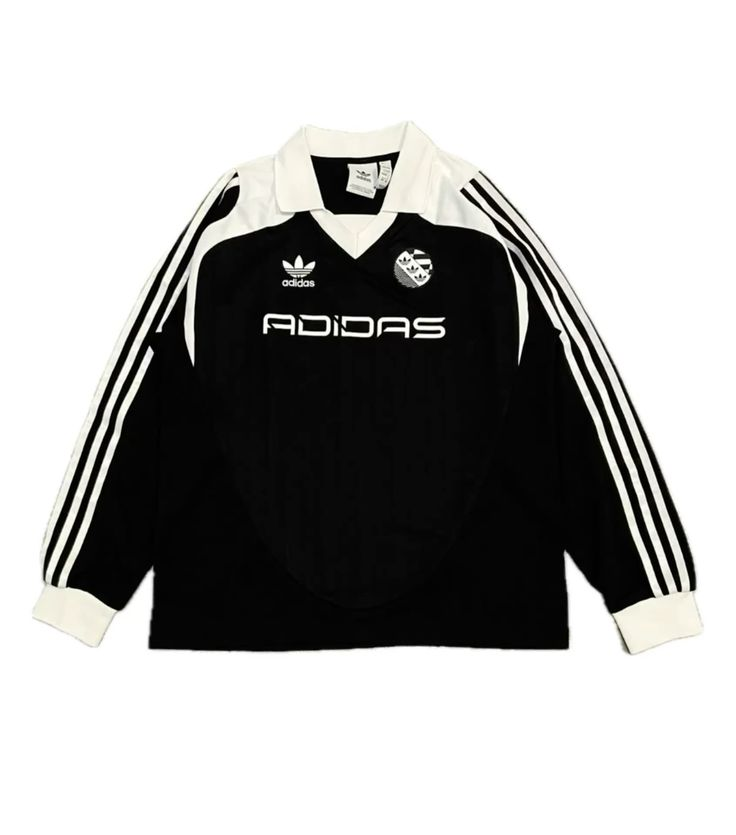

 Added: shirt (confidence: 95.69%)
Category: shirt
Confidence: 95.69%

Processing: 08f0e6a91870aec2725b510d5066babc.jpg


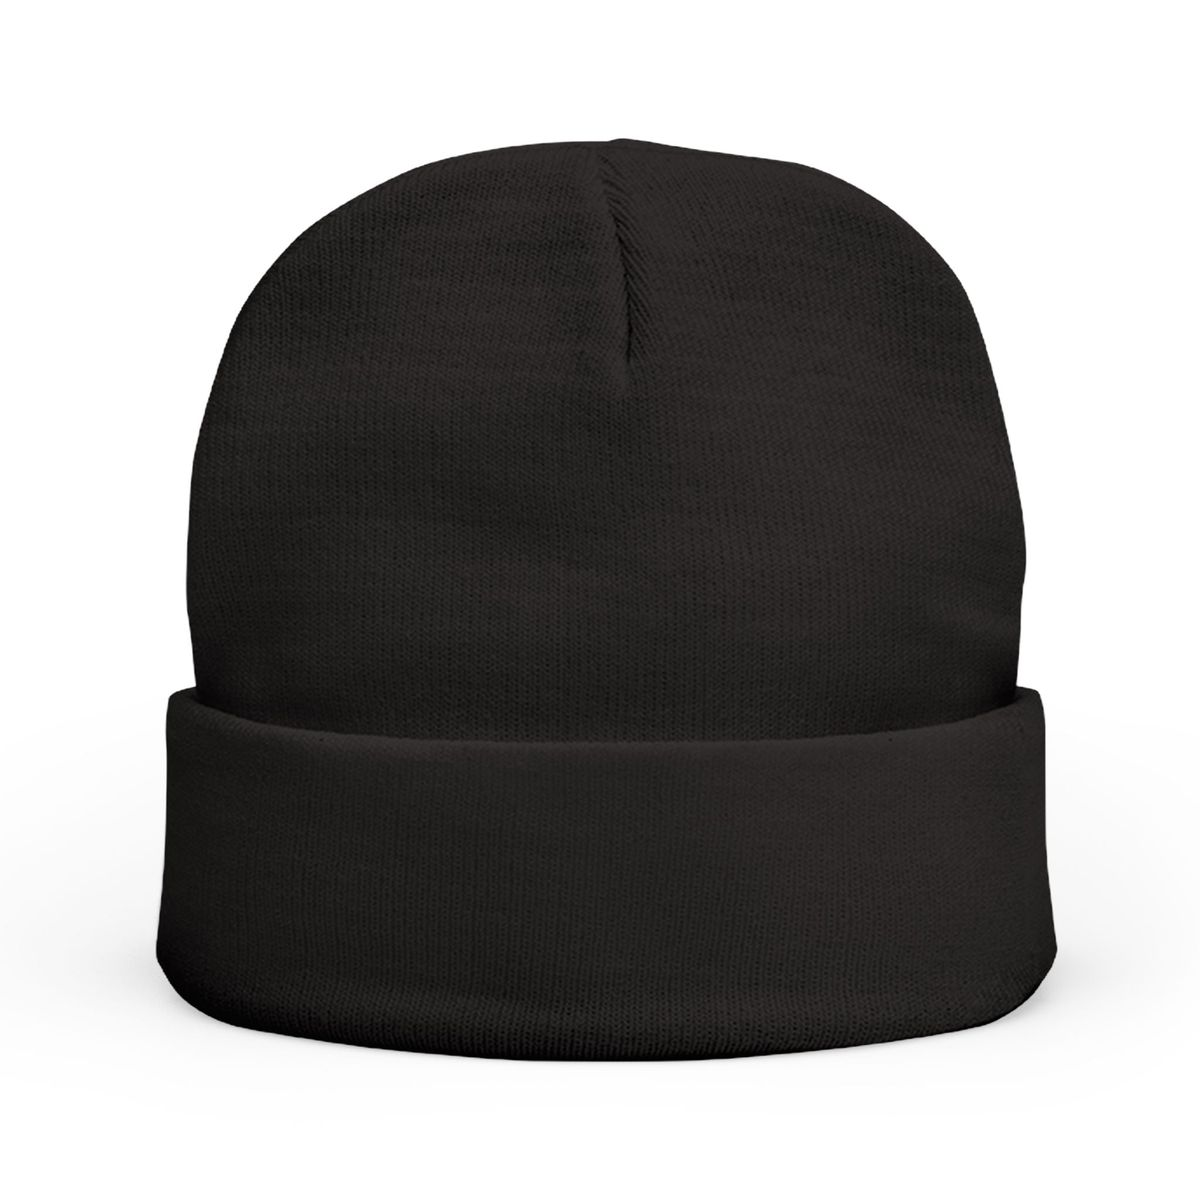

 Added: hat (confidence: 93.16%)
Category: hat
Confidence: 93.16%

Processing: 8a138784ac56d26d20215740d76d106f.jpg


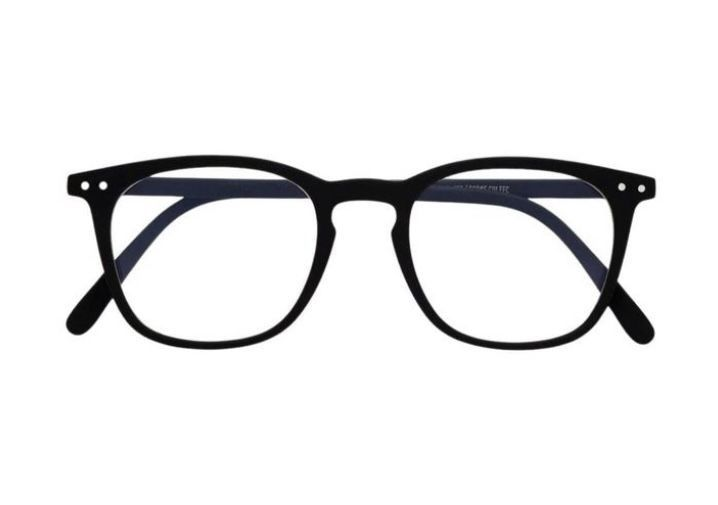

 Added: glasses (confidence: 100.00%)
Category: glasses
Confidence: 100.00%

Processing: 18ad6ee702108e21f2633090e01bd8c3.jpg


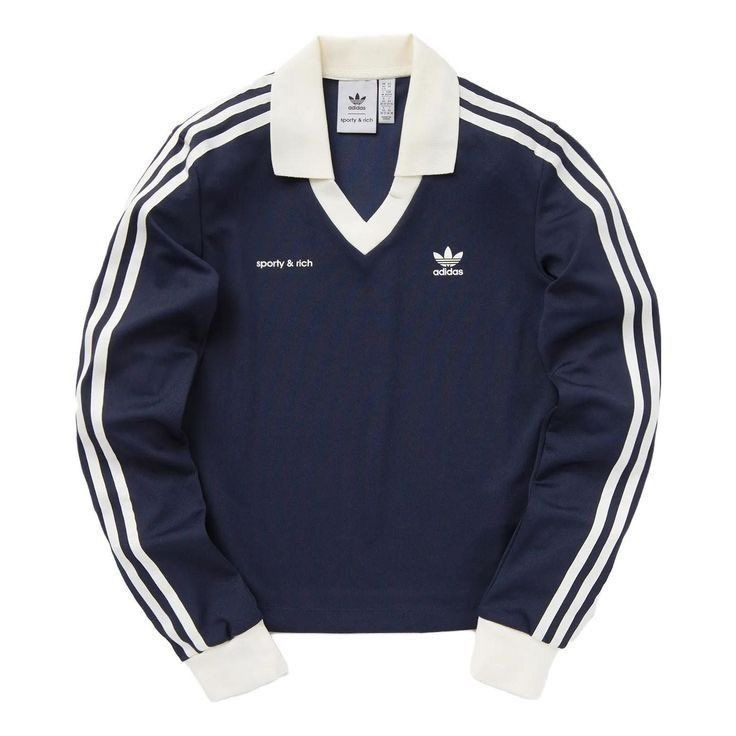

 Added: shirt (confidence: 83.31%)
Category: shirt
Confidence: 83.31%

Processing: 36f562e8637ea1c199344a114ca0ce42.jpg


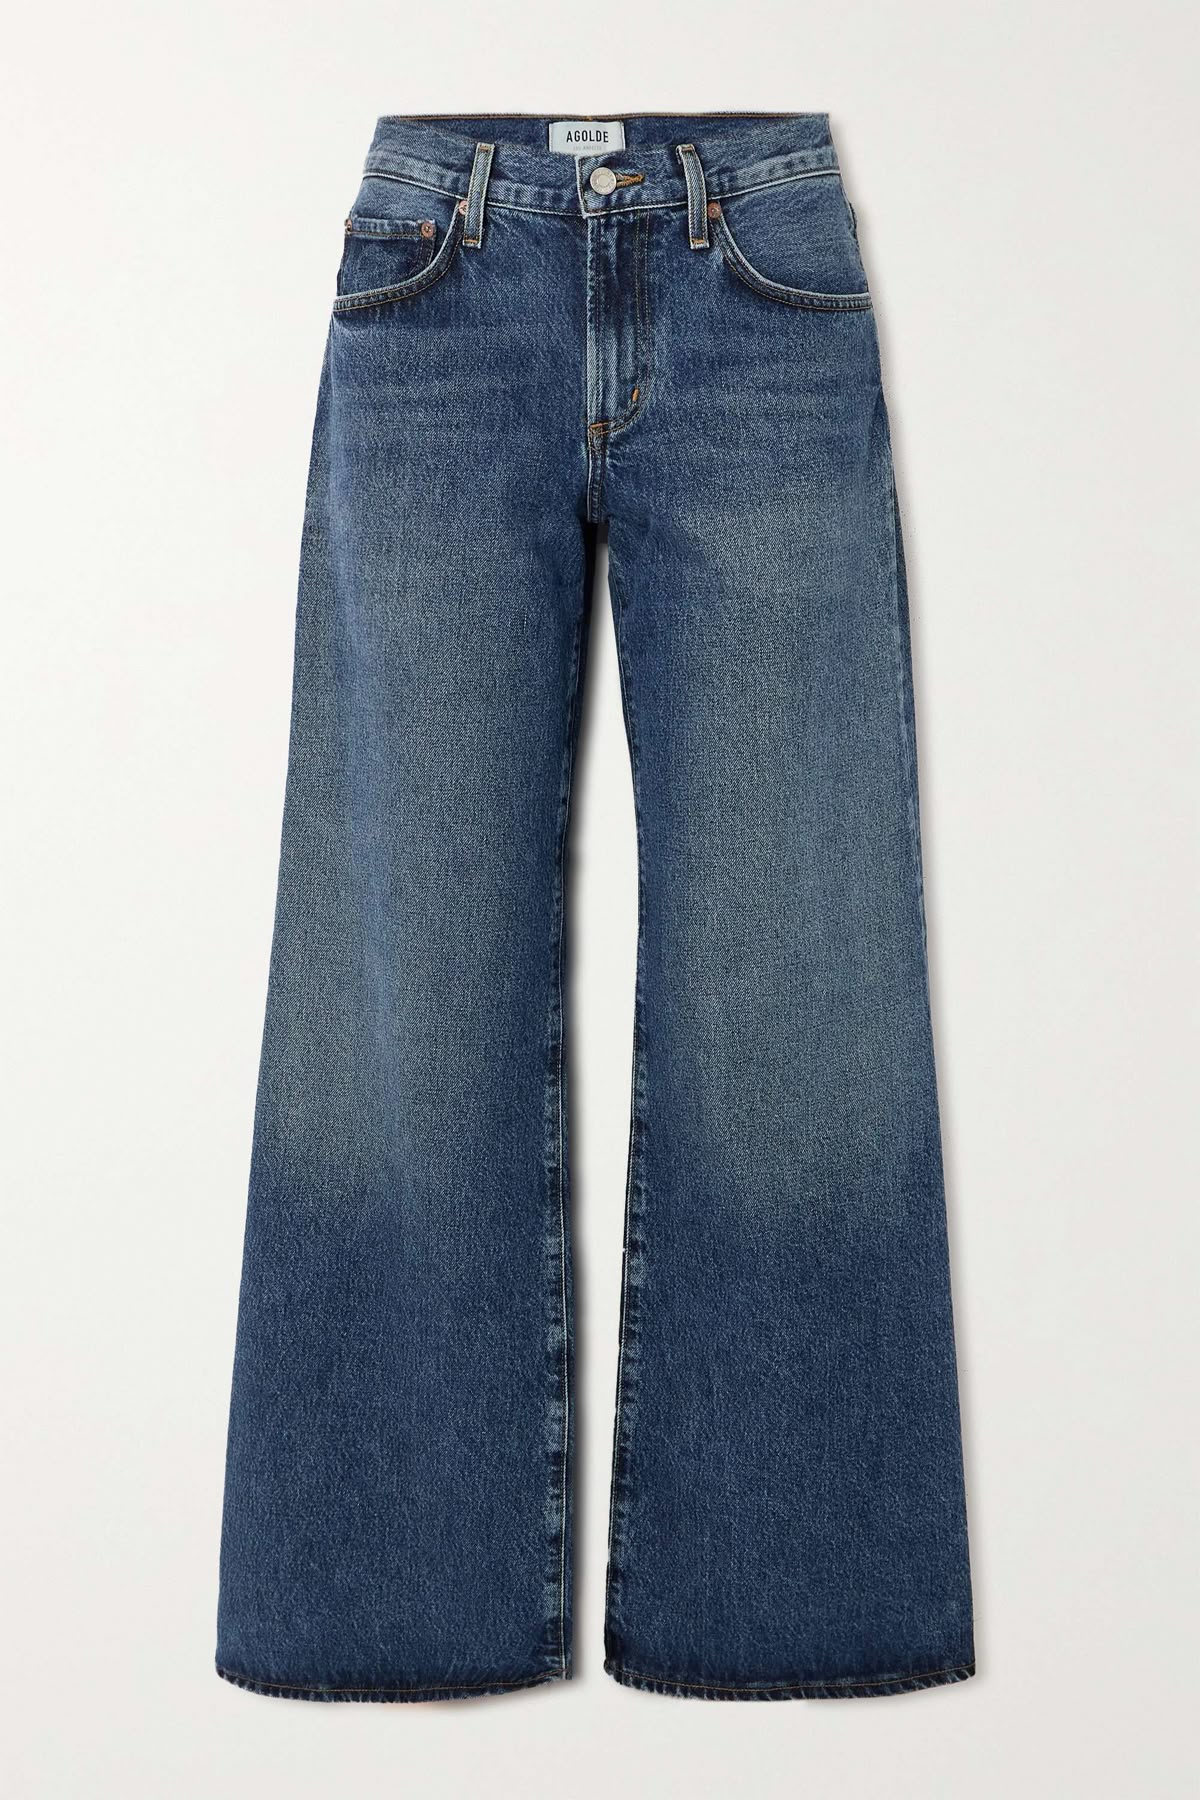

 Added: pants (confidence: 99.97%)
Category: pants
Confidence: 99.97%

Processing: 84e4172c8650f813853e803211e22440.jpg


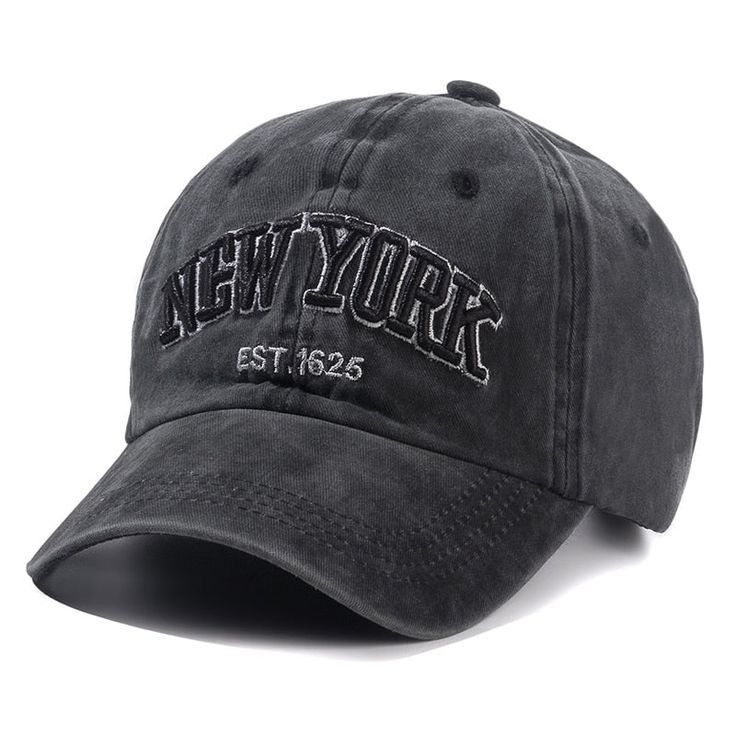

 Added: hat (confidence: 99.29%)
Category: hat
Confidence: 99.29%

Processing: 97c48ff93b12ca85753abe936b35b460.jpg


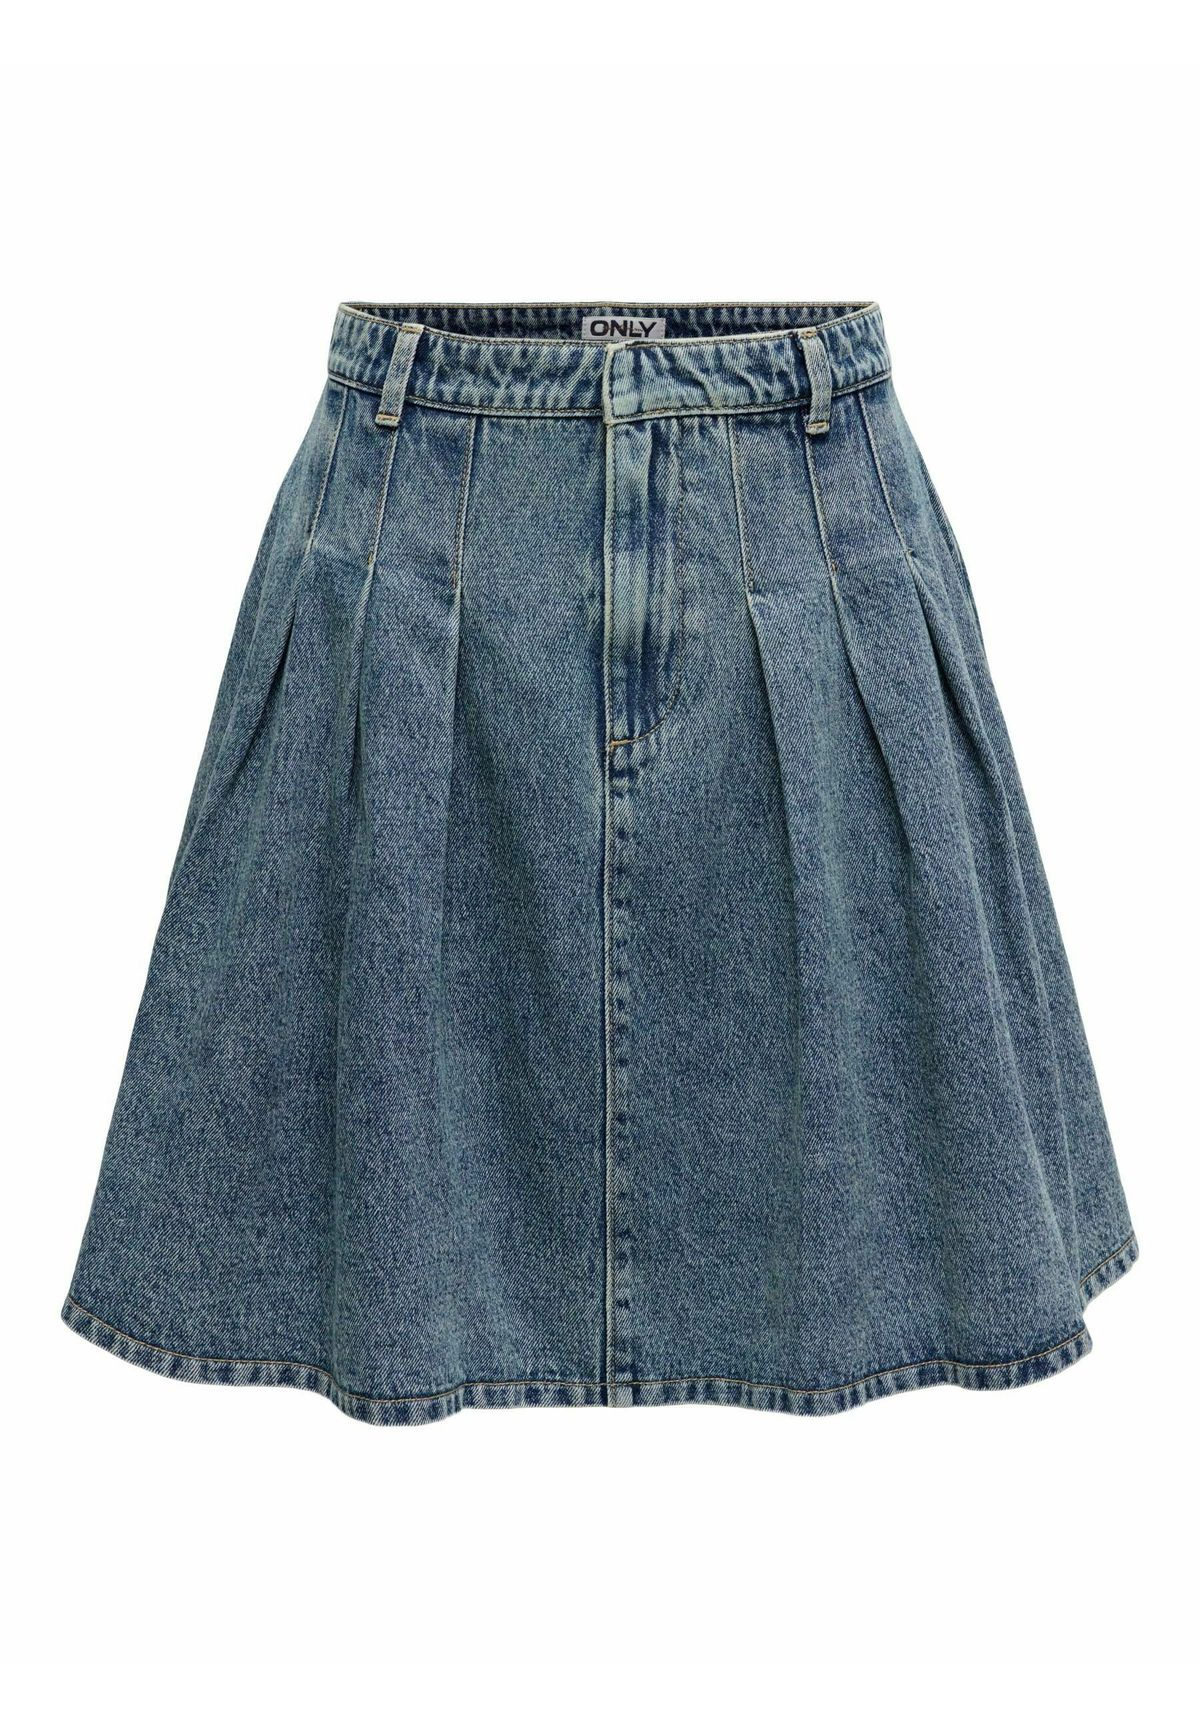

 Added: skirt (confidence: 99.96%)
Category: skirt
Confidence: 99.96%

Processing: 2612c9bcf270c14512a2f7050c1e0c2e.jpg


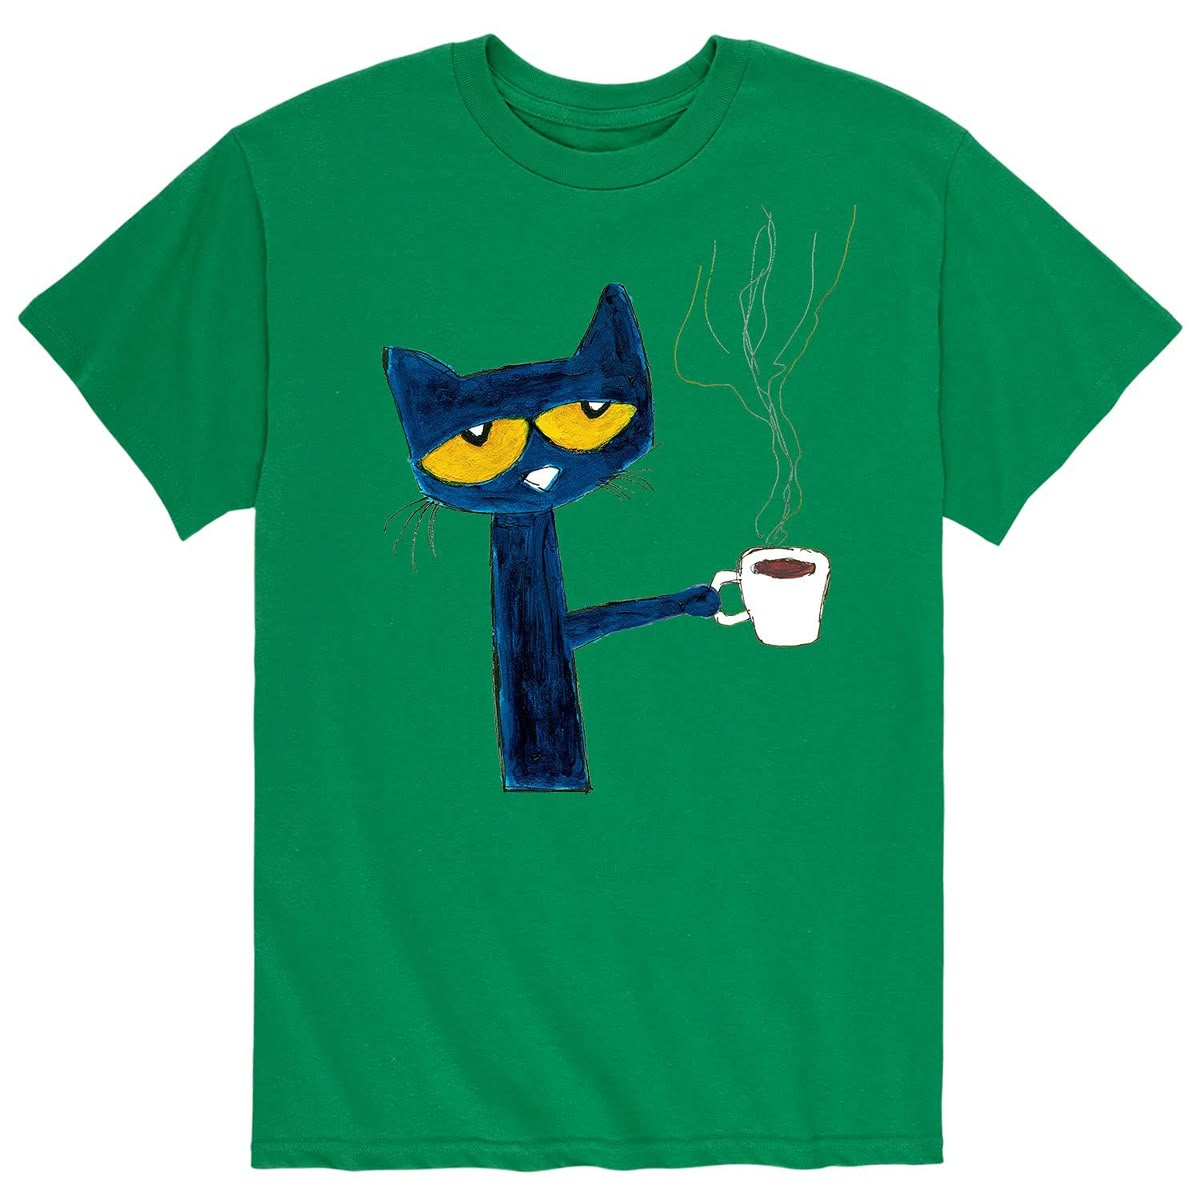

 Added: t-shirt (confidence: 99.93%)
Category: t-shirt
Confidence: 99.93%

Processing: 4734d191ac9282558254ff811c47d5be.jpg


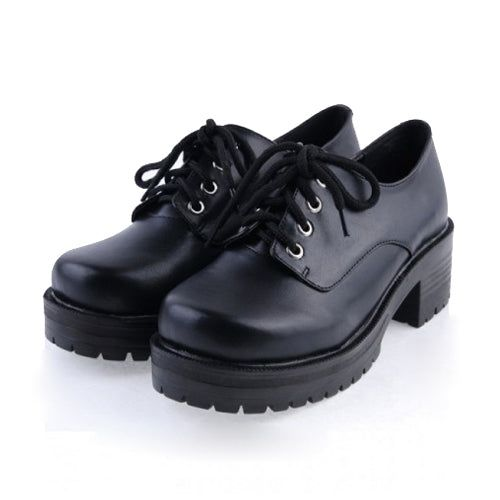

 Added: shoes (confidence: 100.00%)
Category: shoes
Confidence: 100.00%

Processing: 8816bd7e5aa155ea36124bc8f24a8691.jpg


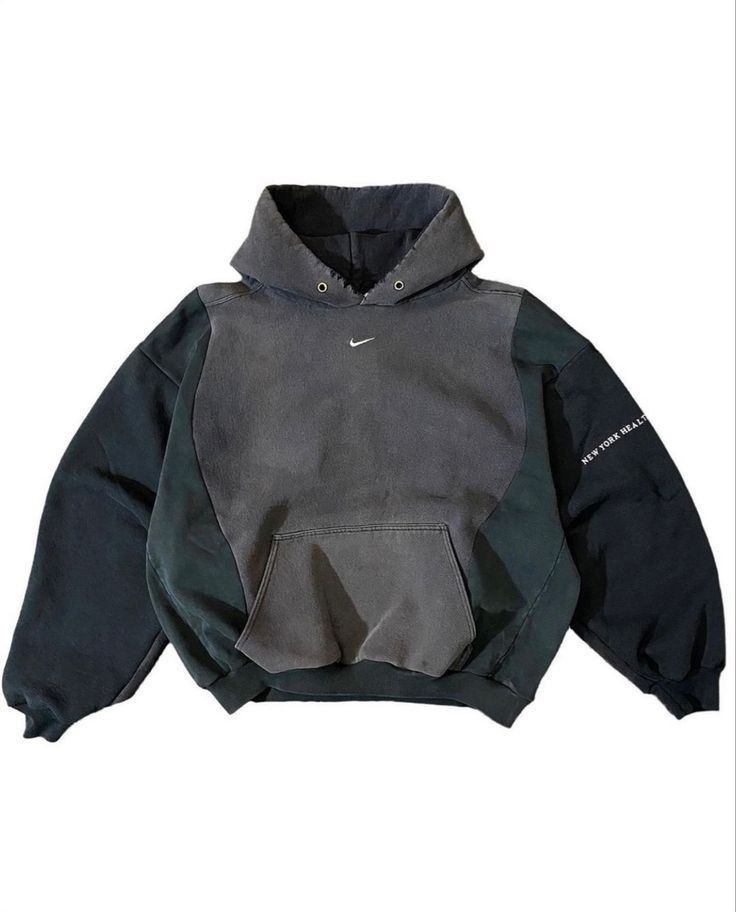

 Added: outwear (confidence: 72.06%)
Category: outwear
Confidence: 72.06%

Processing: 52776a5628f9e6e65355400b65d9f0bb.jpg


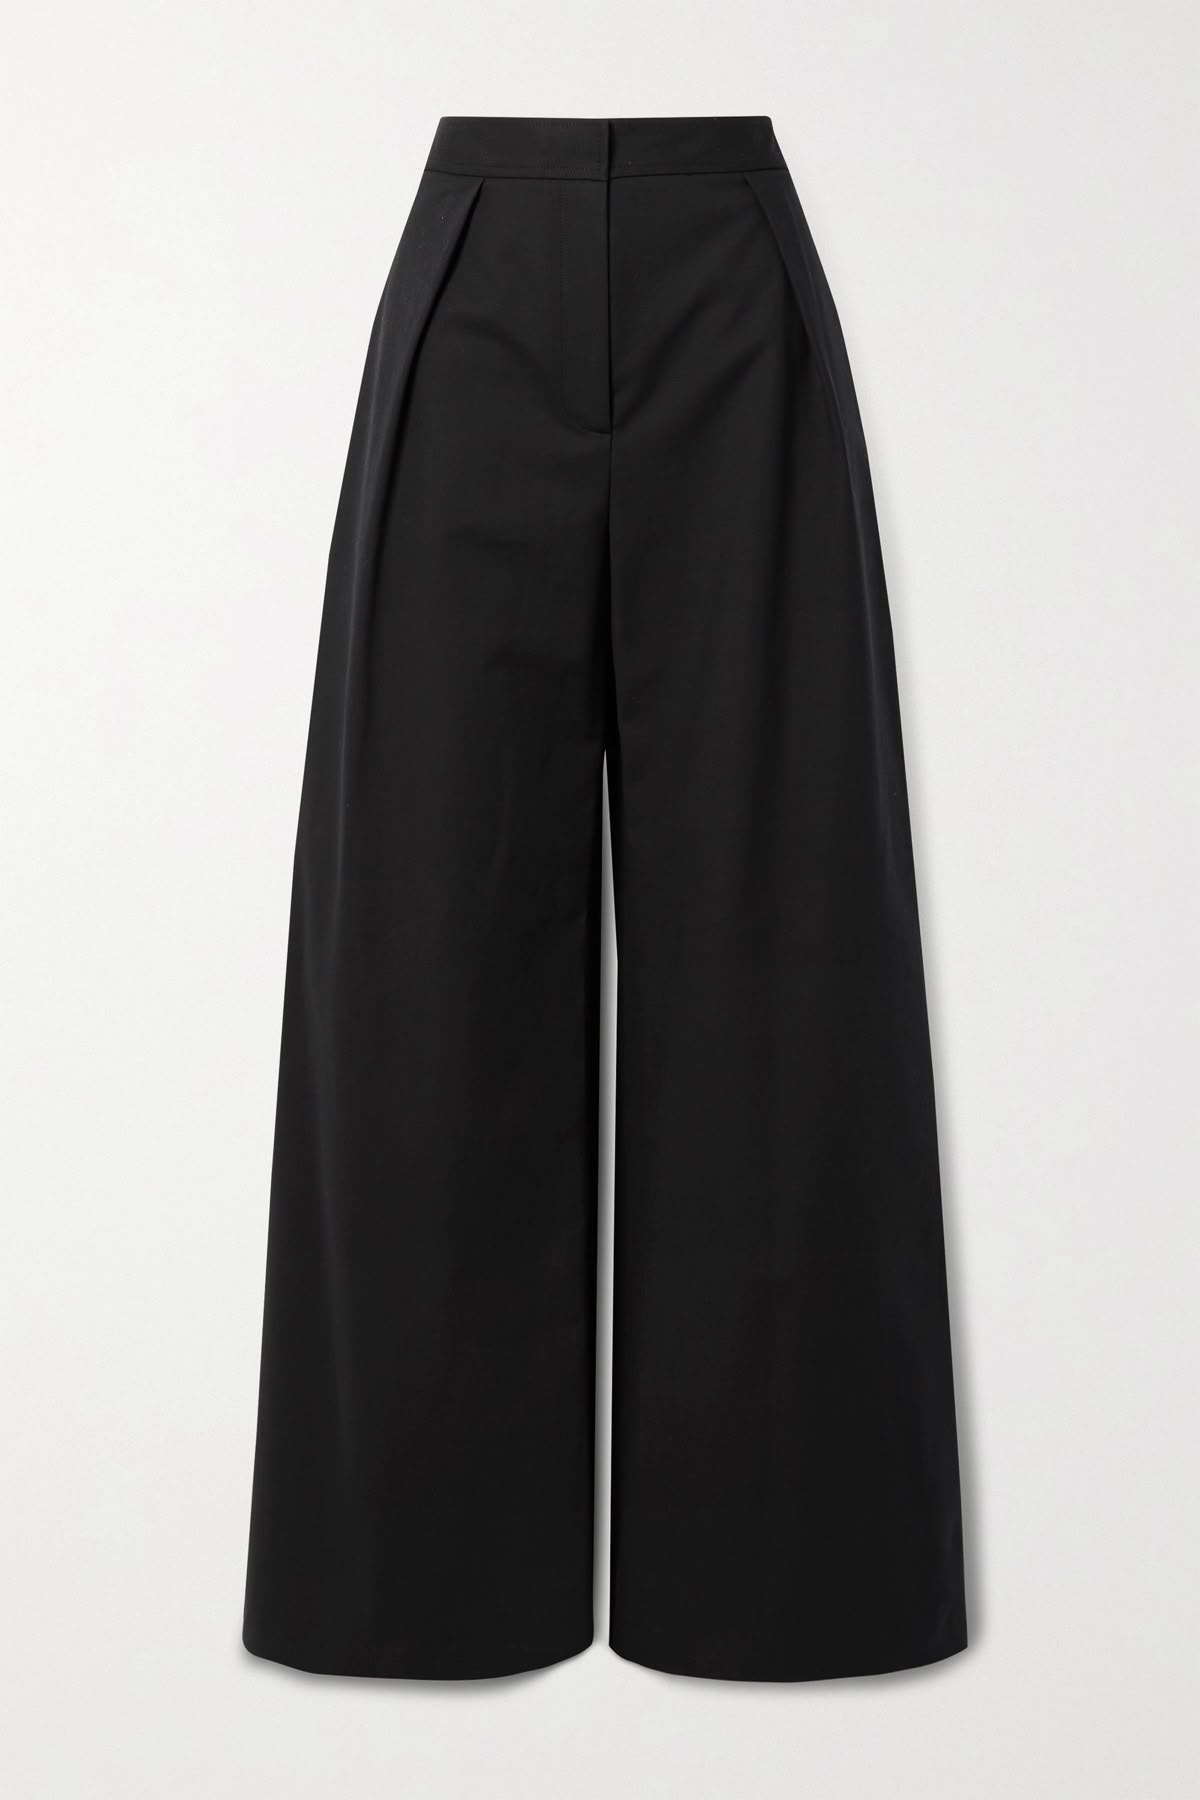

 Added: pants (confidence: 67.50%)
Category: pants
Confidence: 67.50%

Processing: 05480785069e732109695753a095707a.jpg


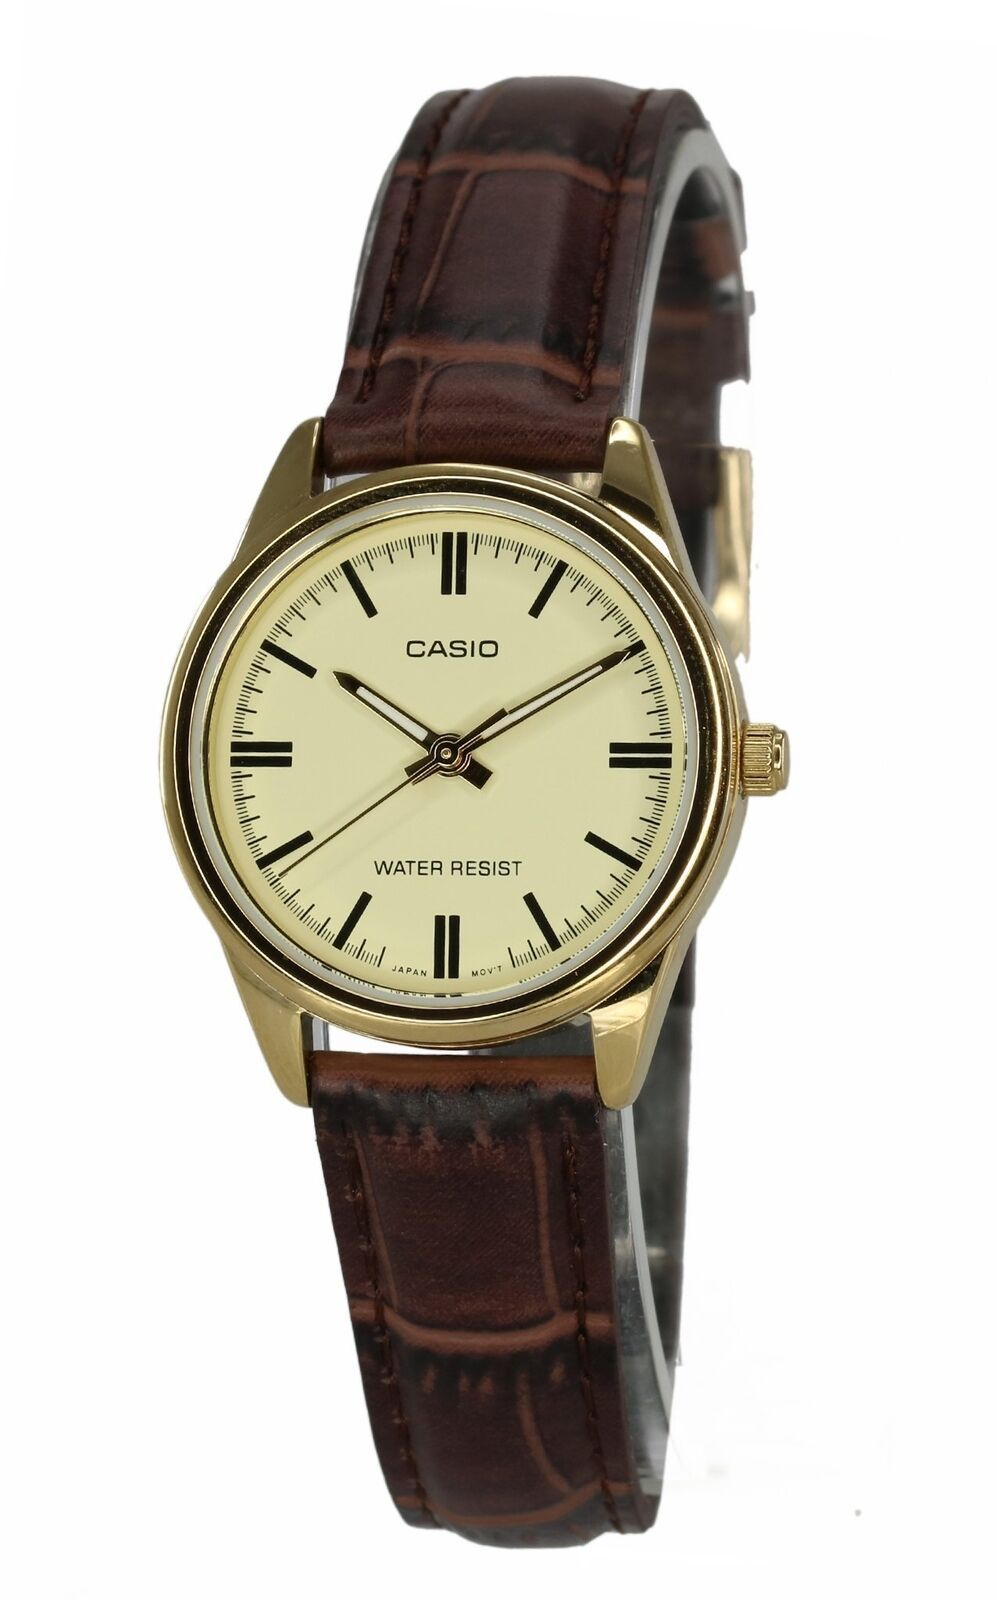

 Added: watches (confidence: 100.00%)
Category: watches
Confidence: 100.00%


In [ ]:
def add_clothing_items():
    # Upload images and add to wardrobe
    from google.colab import files
    from IPython.display import Image, display

    print("Upload clothing images...")
    uploaded = files.upload()

    for filename, data in uploaded.items():
        # Save uploaded file
        filepath = f"{BASE_DIR}/uploads/{filename}"
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        with open(filepath, 'wb') as f:
            f.write(data)

        # Display image
        print(f"\n{'='*60}")
        print(f"Processing: {filename}")
        display(Image(filepath, width=200))

        # Add to wardrobe
        item = manager.add_item(filepath)
        print(f"Category: {item.category}")
        print(f"Confidence: {item.confidence:.2%}")

add_clothing_items()

In [ ]:
def predict_image(image_path, classifier):
    CLASS_NAMES = ['glasses', 'hat', 'outwear', 'pants', 'shirt', 'shoes', 'skirt', 't-shirt', 'watches']

    # Load and preprocess
    img = load_img(image_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = classifier.predict(img_array)[0]

    class_id = np.argmax(preds)
    confidence = preds[class_id]

    return CLASS_NAMES[class_id], confidence

GENERATING OUTFIT RECOMMENDATION

✓ Outfit Score: 0.63/1.00
Type: complete_outfit
YOUR COMPLETE OUTFIT

TOP:
   1. SHIRT
      Confidence: 95.69%
      Added: 2025-11-30T20:33:31.417899


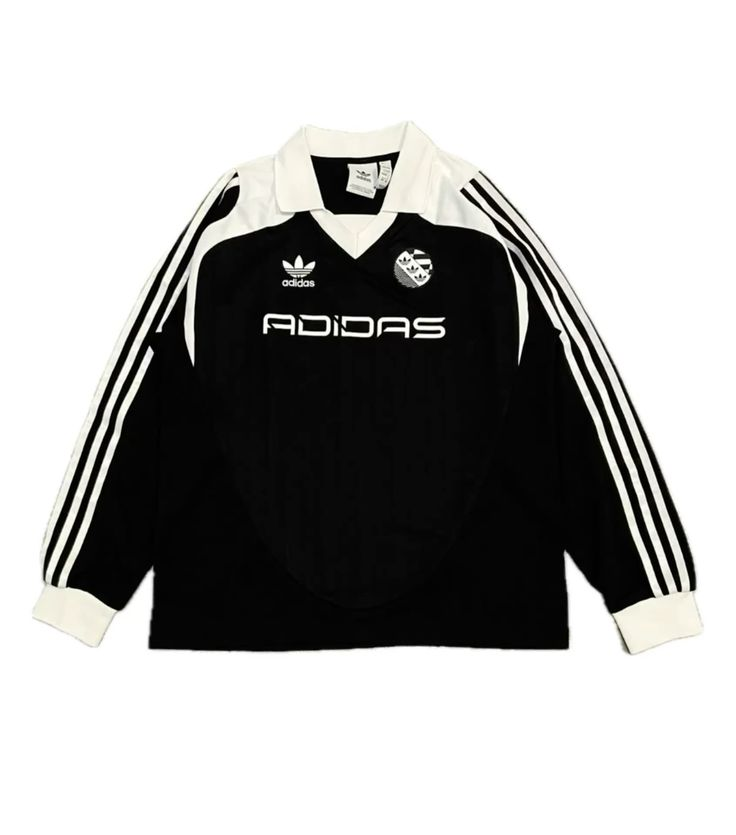


BOTTOM:
   2. SKIRT
      Confidence: 99.96%
      Added: 2025-11-30T20:33:37.163374


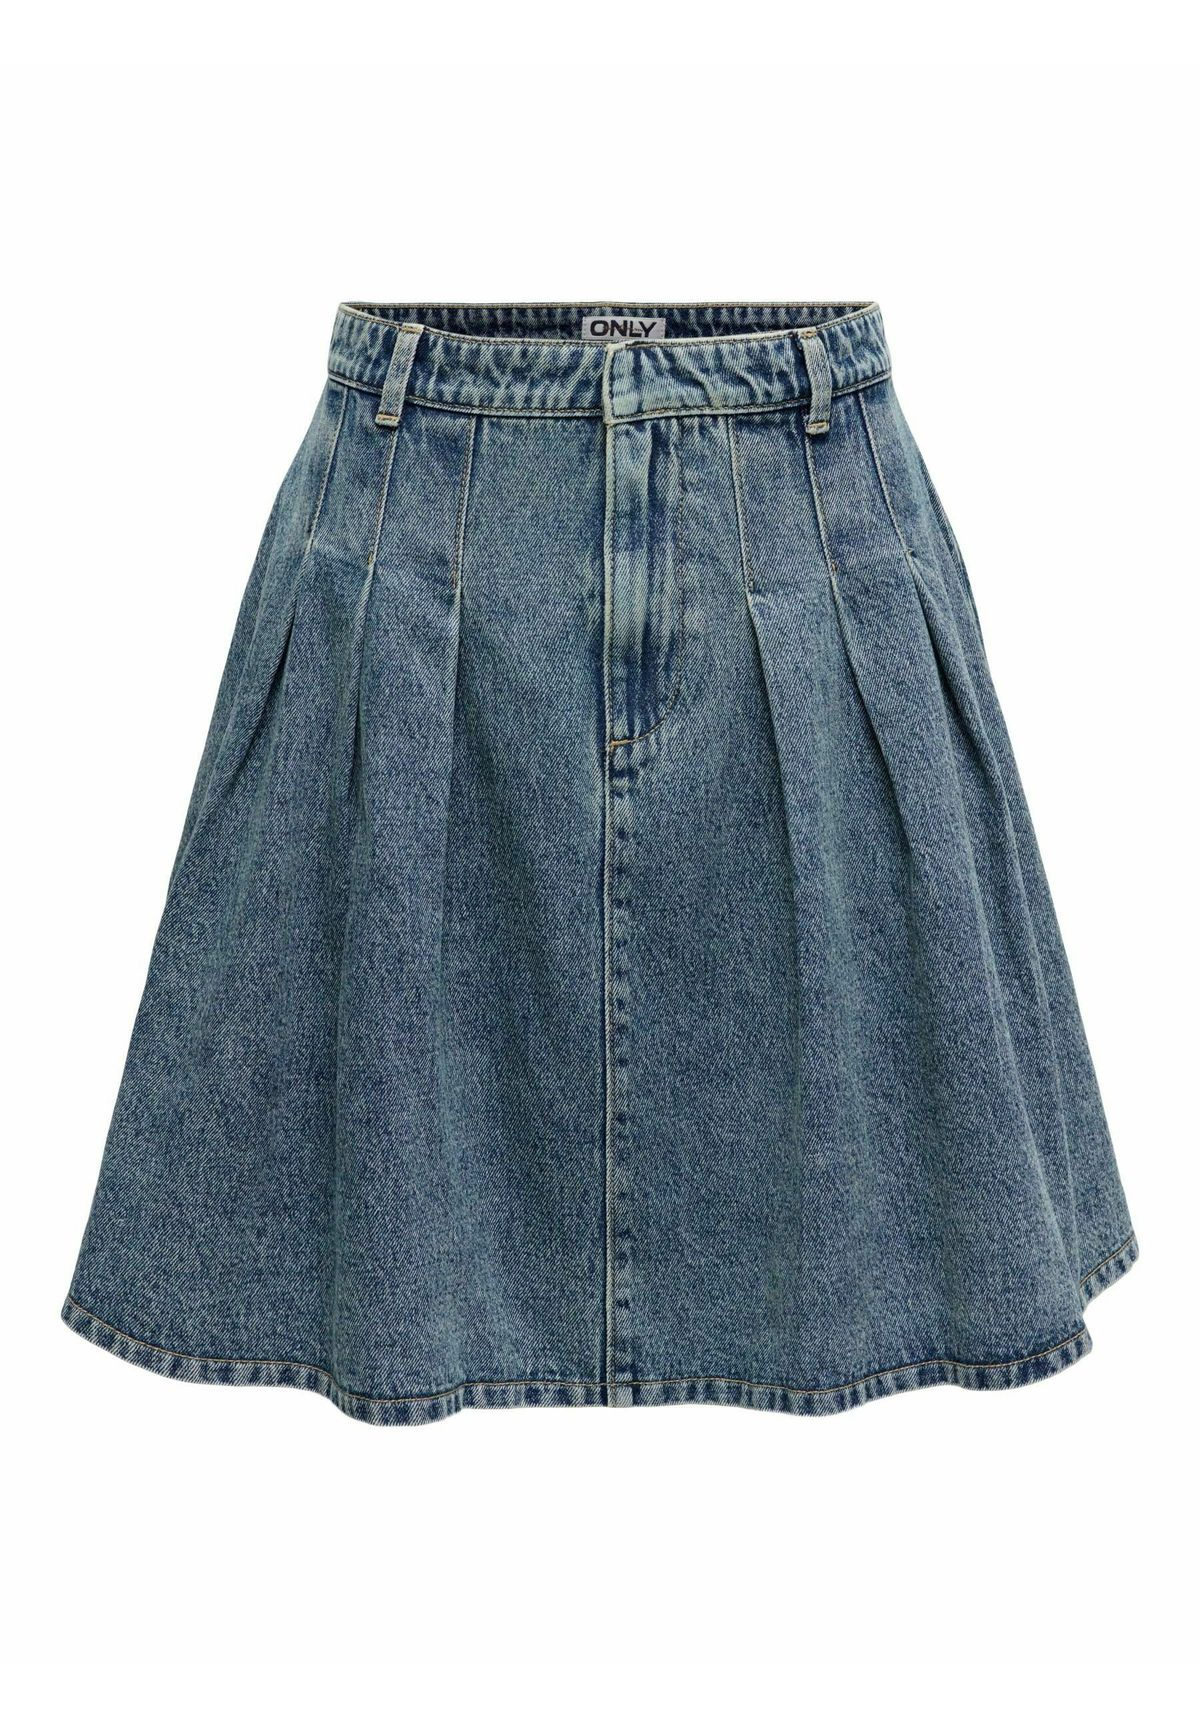


SHOES:
   3. SHOES
      Confidence: 100.00%
      Added: 2025-11-30T20:33:37.817065


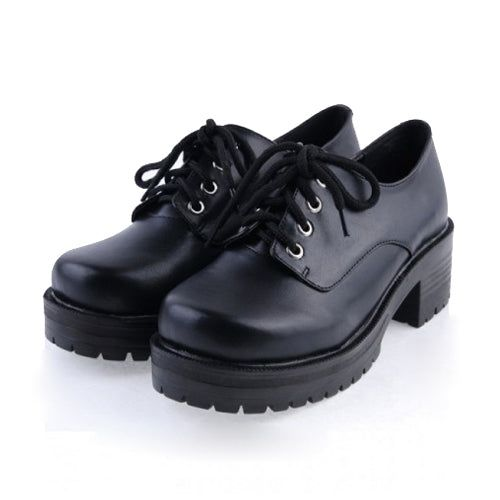


OUTER LAYER:
   4. OUTWEAR
      Confidence: 72.06%
      Added: 2025-11-30T20:33:38.147580


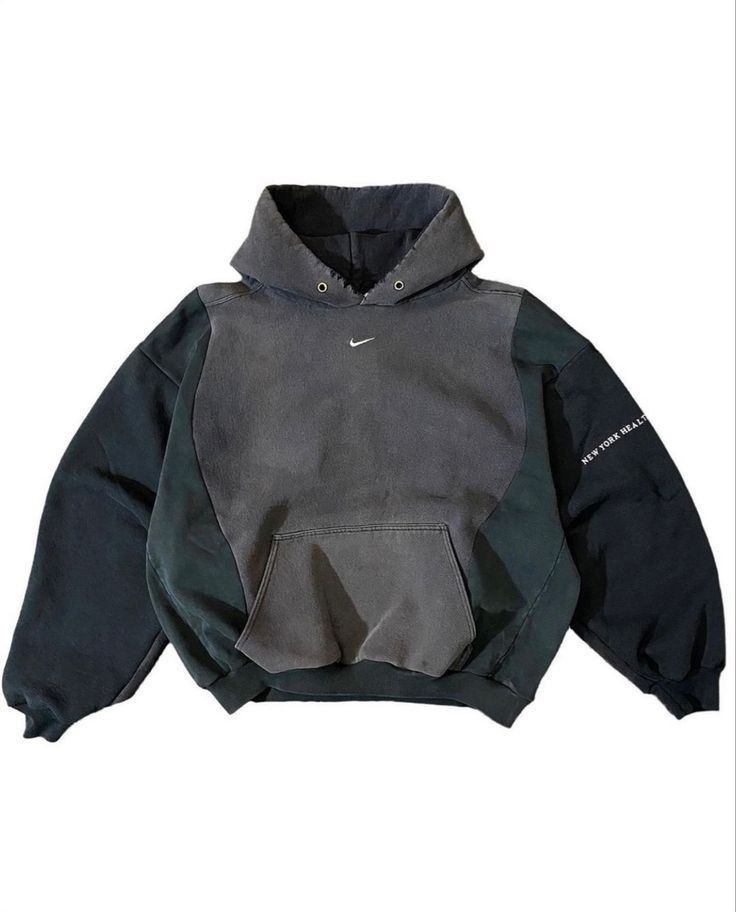


ACCESSORIES:
   5. GLASSES
      Confidence: 100.00%
      Added: 2025-11-30T20:33:36.097768


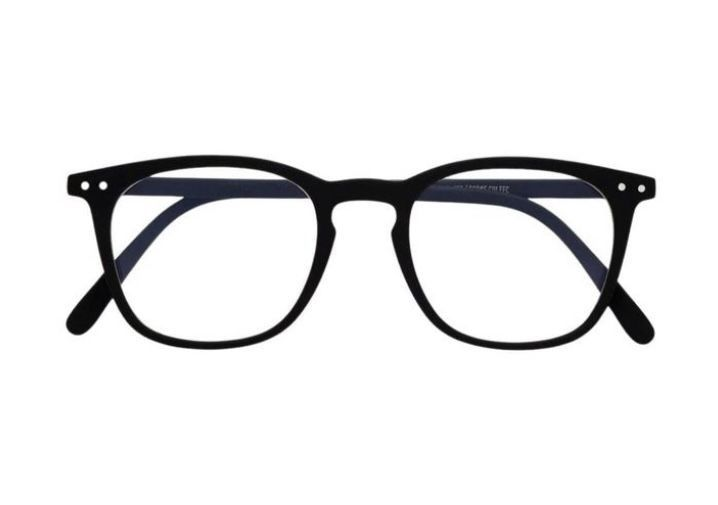

   6. HAT
      Confidence: 99.29%
      Added: 2025-11-30T20:33:36.759190


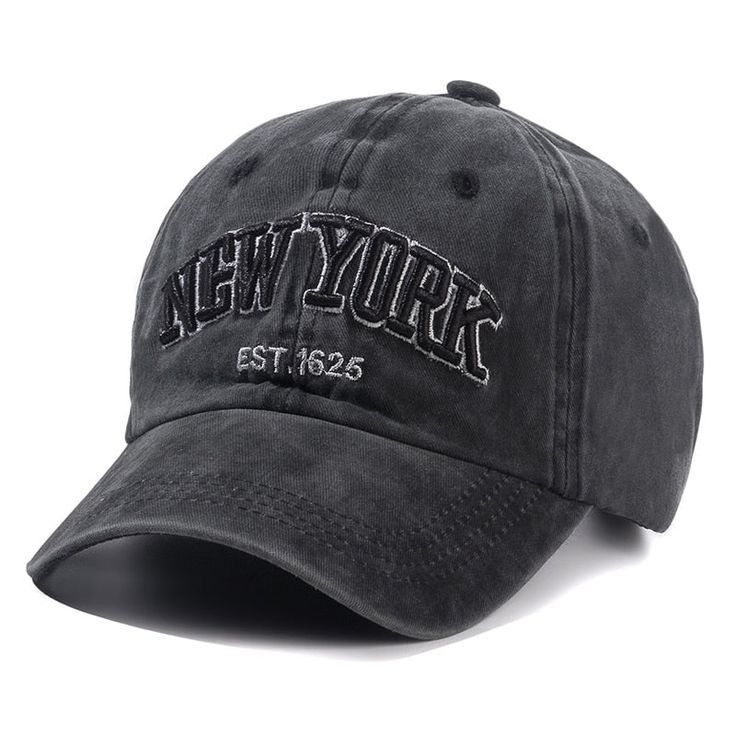

   7. WATCHES
      Confidence: 100.00%
      Added: 2025-11-30T20:33:38.837030


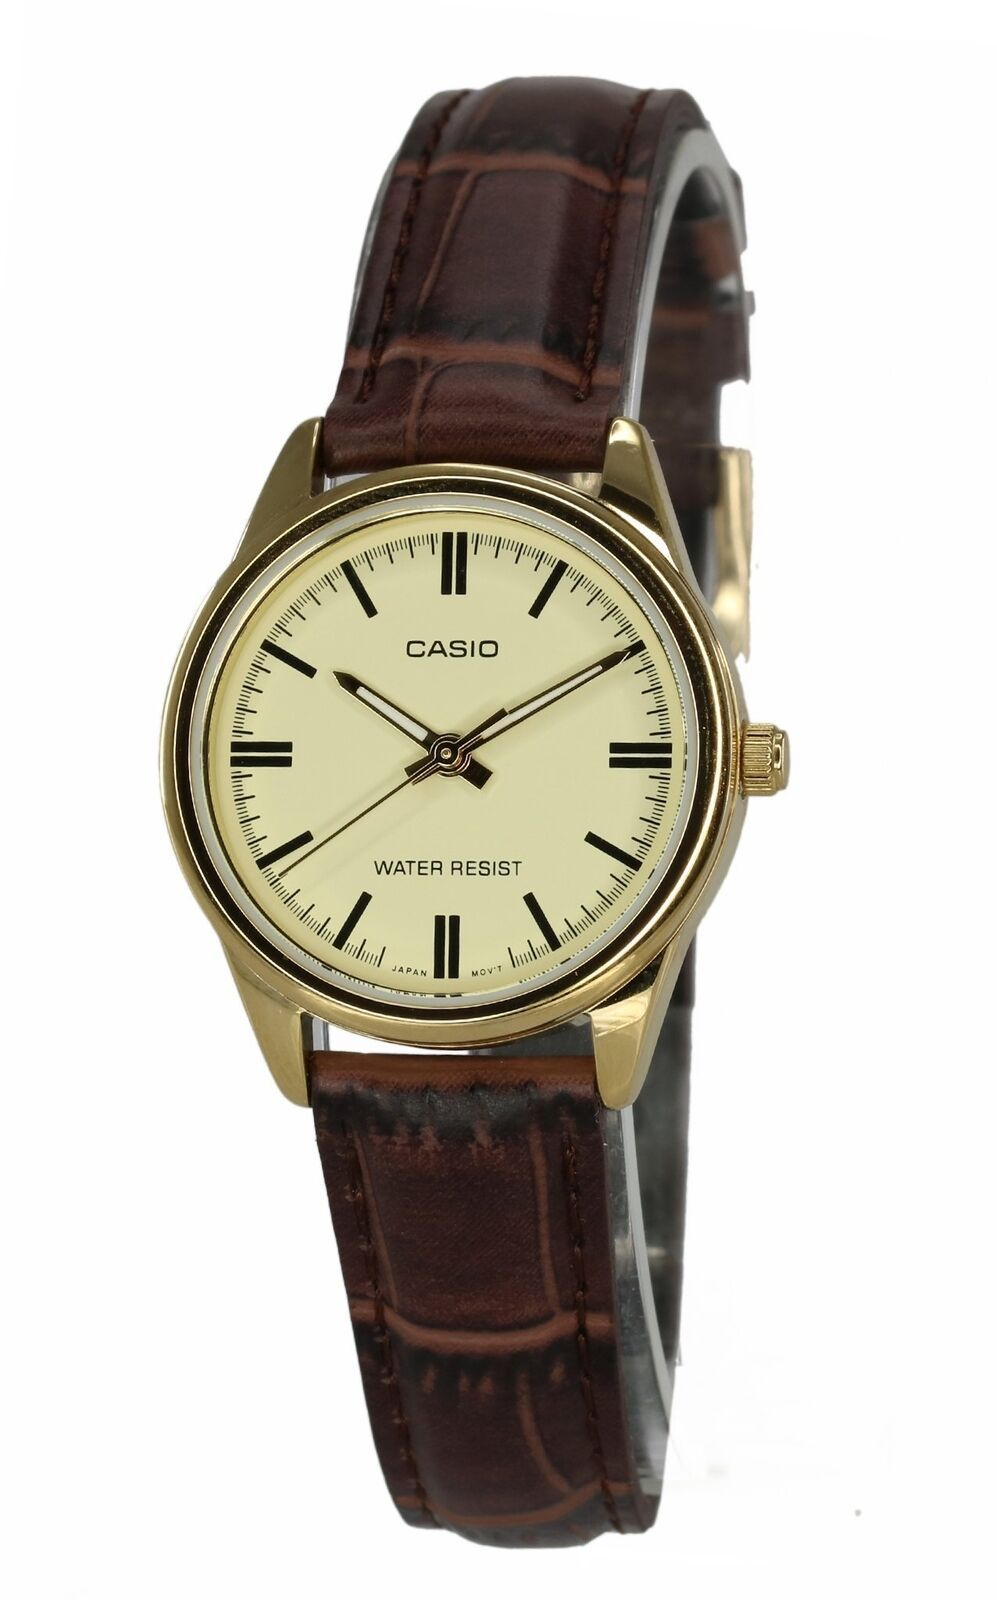

{'success': True,
 'items': [WardrobeItem(id='item_0_20251130_203331', image_path='/content/drive/MyDrive/Clothes-Project/uploads/3cbceacea3e18b4b496484616b71fcf2.jpg', category='shirt', simplified_category='top', confidence=0.9568630456924438, embedding=array([0.        , 0.00264893, 0.        , ..., 0.        , 0.00354772,
         0.00353662], dtype=float32), added_date='2025-11-30T20:33:31.417899'),
  WardrobeItem(id='item_6_20251130_203337', image_path='/content/drive/MyDrive/Clothes-Project/uploads/97c48ff93b12ca85753abe936b35b460.jpg', category='skirt', simplified_category='bottom', confidence=0.999579131603241, embedding=array([0.        , 0.00028667, 0.        , ..., 0.02342028, 0.        ,
         0.        ], dtype=float32), added_date='2025-11-30T20:33:37.163374'),
  WardrobeItem(id='item_8_20251130_203337', image_path='/content/drive/MyDrive/Clothes-Project/uploads/4734d191ac9282558254ff811c47d5be.jpg', category='shoes', simplified_category='shoes', confidence=0.999998211

In [ ]:
def show_outfit_recommendation(include_accessories=True):
    # Generate and display outfit recommendation
    from IPython.display import Image, display

    print("GENERATING OUTFIT RECOMMENDATION")

    result = manager.get_outfit_recommendation(include_accessories=include_accessories)

    if result['success']:
        print(f"\n✓ Outfit Score: {result['score']:.2f}/1.00")
        print(f"Type: {result['type']}")

        # Display breakdown by category
        if 'breakdown' in result:
            breakdown = result['breakdown']

            print("YOUR COMPLETE OUTFIT")

            # Display by category
            categories_display = [
                ('TOP', 'top'),
                ('BOTTOM', 'bottom'),
                ('SHOES', 'shoes'),
                ('OUTER LAYER', 'outer'),
                ('ACCESSORIES', 'accessories')
            ]

            item_count = 1
            for display_name, cat_key in categories_display:
                items = breakdown.get(cat_key, [])
                if items:
                    print(f"\n{display_name}:")
                    for item in items:
                        print(f"   {item_count}. {item.category.upper()}")
                        print(f"      Confidence: {item.confidence:.2%}")
                        print(f"      Added: {item.added_date}")

                        # Display image
                        if os.path.exists(item.image_path):
                            img_path = Path(item.image_path).resolve()
                            display(Image(str(img_path), width=200))
                        item_count += 1
        else:
            # Fallback to simple display
            print("\nYour Outfit:")
            for i, item in enumerate(result['items'], 1):
                print(f"\n{i}. {item.category.upper()} ({item.simplified_category})")
                print(f"   Confidence: {item.confidence:.2%}")
                print(f"   Added: {item.added_date}")

                if os.path.exists(item.image_path):
                    display(Image(item.image_path, width=200))
    else:
        print(f"{result['message']}")

    return result

show_outfit_recommendation(include_accessories=True)

In [ ]:
manager.list_items()

WARDROBE INVENTORY (12 items)
item_0_20251130_203331: shirt (top) - 95.69%
item_1_20251130_203335: hat (accessory) - 93.16%
item_2_20251130_203336: glasses (accessory) - 100.00%
item_3_20251130_203336: shirt (top) - 83.31%
item_4_20251130_203336: pants (bottom) - 99.97%
item_5_20251130_203336: hat (accessory) - 99.29%
item_6_20251130_203337: skirt (bottom) - 99.96%
item_7_20251130_203337: t-shirt (top) - 99.93%
item_8_20251130_203337: shoes (shoes) - 100.00%
item_9_20251130_203338: outwear (outer) - 72.06%
item_10_20251130_203338: pants (bottom) - 67.50%
item_11_20251130_203338: watches (accessory) - 100.00%


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Loading models...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Models loaded!

GENERATING OUTFIT RECOMMENDATION

✓ Outfit Score: 0.63/1.00
Type: complete_outfit
YOUR COMPLETE OUTFIT

TOP:
   1. SHIRT
      Confidence: 95.69%
      Added: 2025-11-30T20:33:31.417899


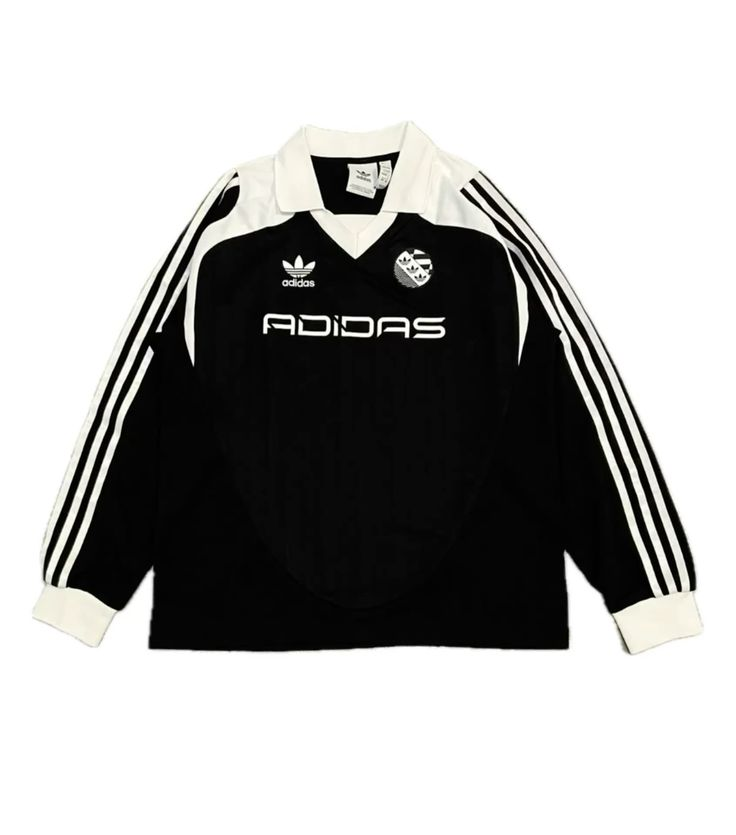


BOTTOM:
   2. SKIRT
      Confidence: 99.96%
      Added: 2025-11-30T20:33:37.163374


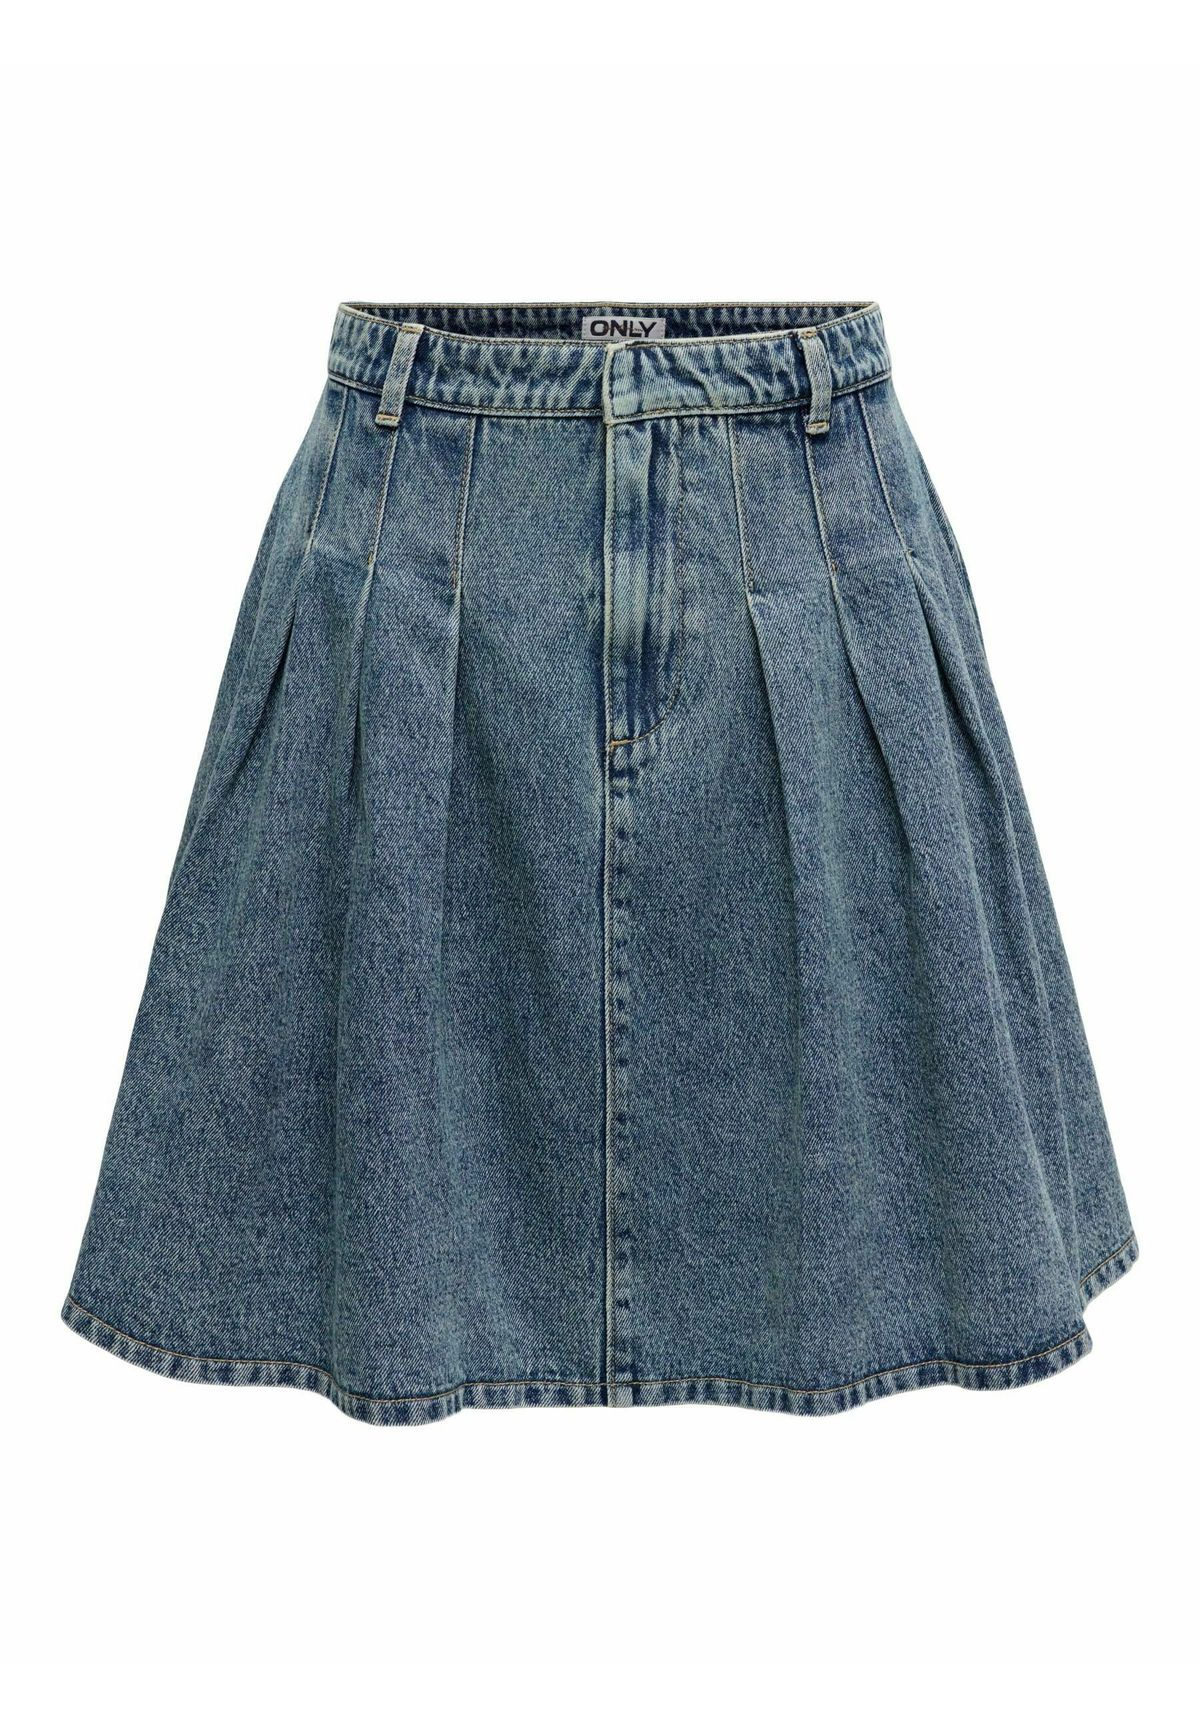


SHOES:
   3. SHOES
      Confidence: 100.00%
      Added: 2025-11-30T20:33:37.817065


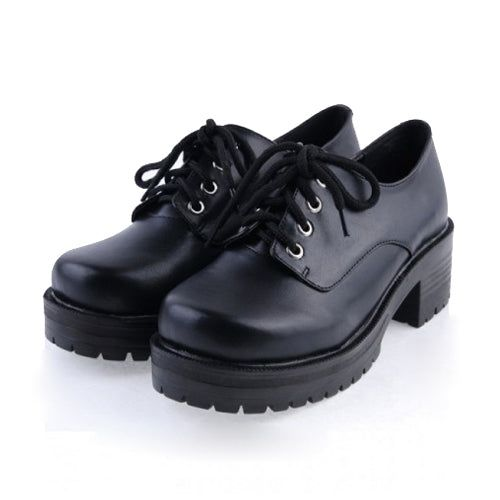


OUTER LAYER:
   4. OUTWEAR
      Confidence: 72.06%
      Added: 2025-11-30T20:33:38.147580


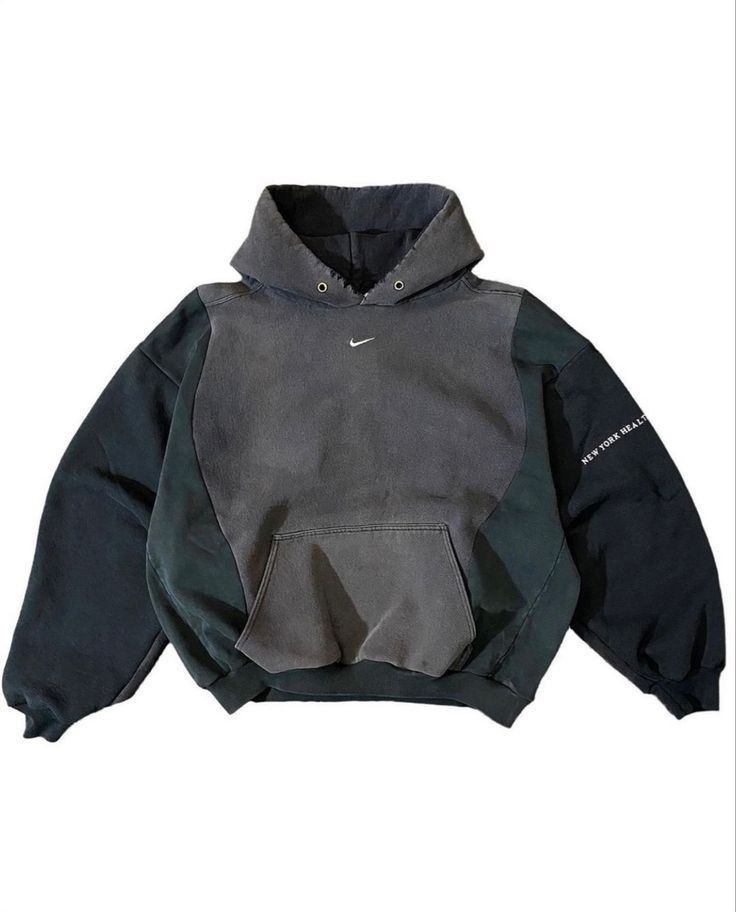


ACCESSORIES:
   5. GLASSES
      Confidence: 100.00%
      Added: 2025-11-30T20:33:36.097768


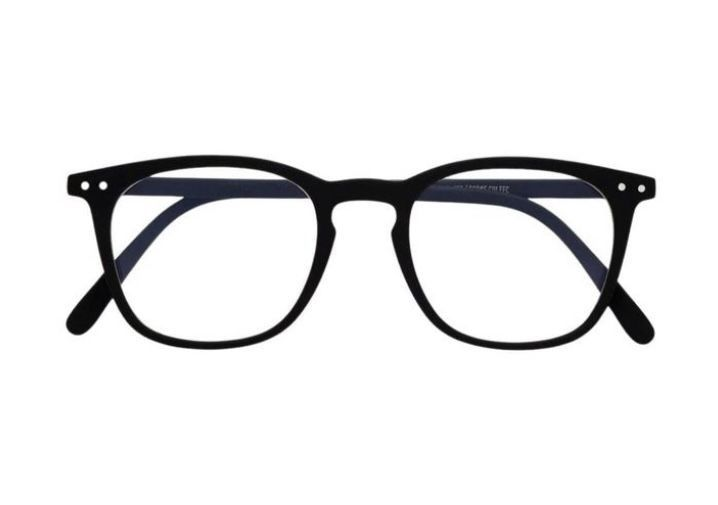

   6. HAT
      Confidence: 93.16%
      Added: 2025-11-30T20:33:35.911202


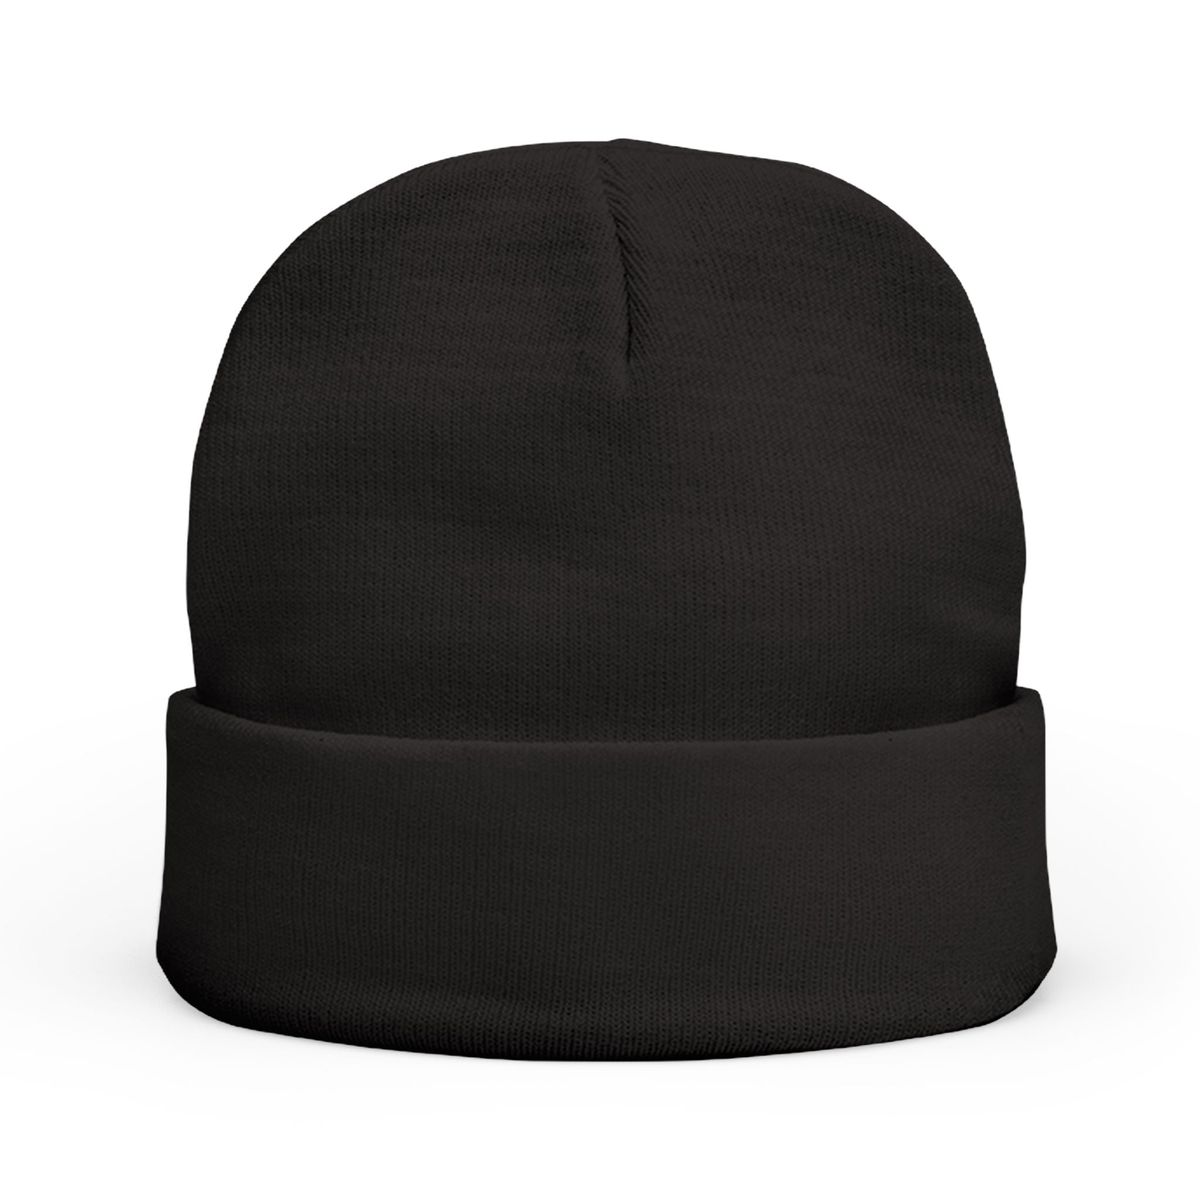

   7. WATCHES
      Confidence: 100.00%
      Added: 2025-11-30T20:33:38.837030


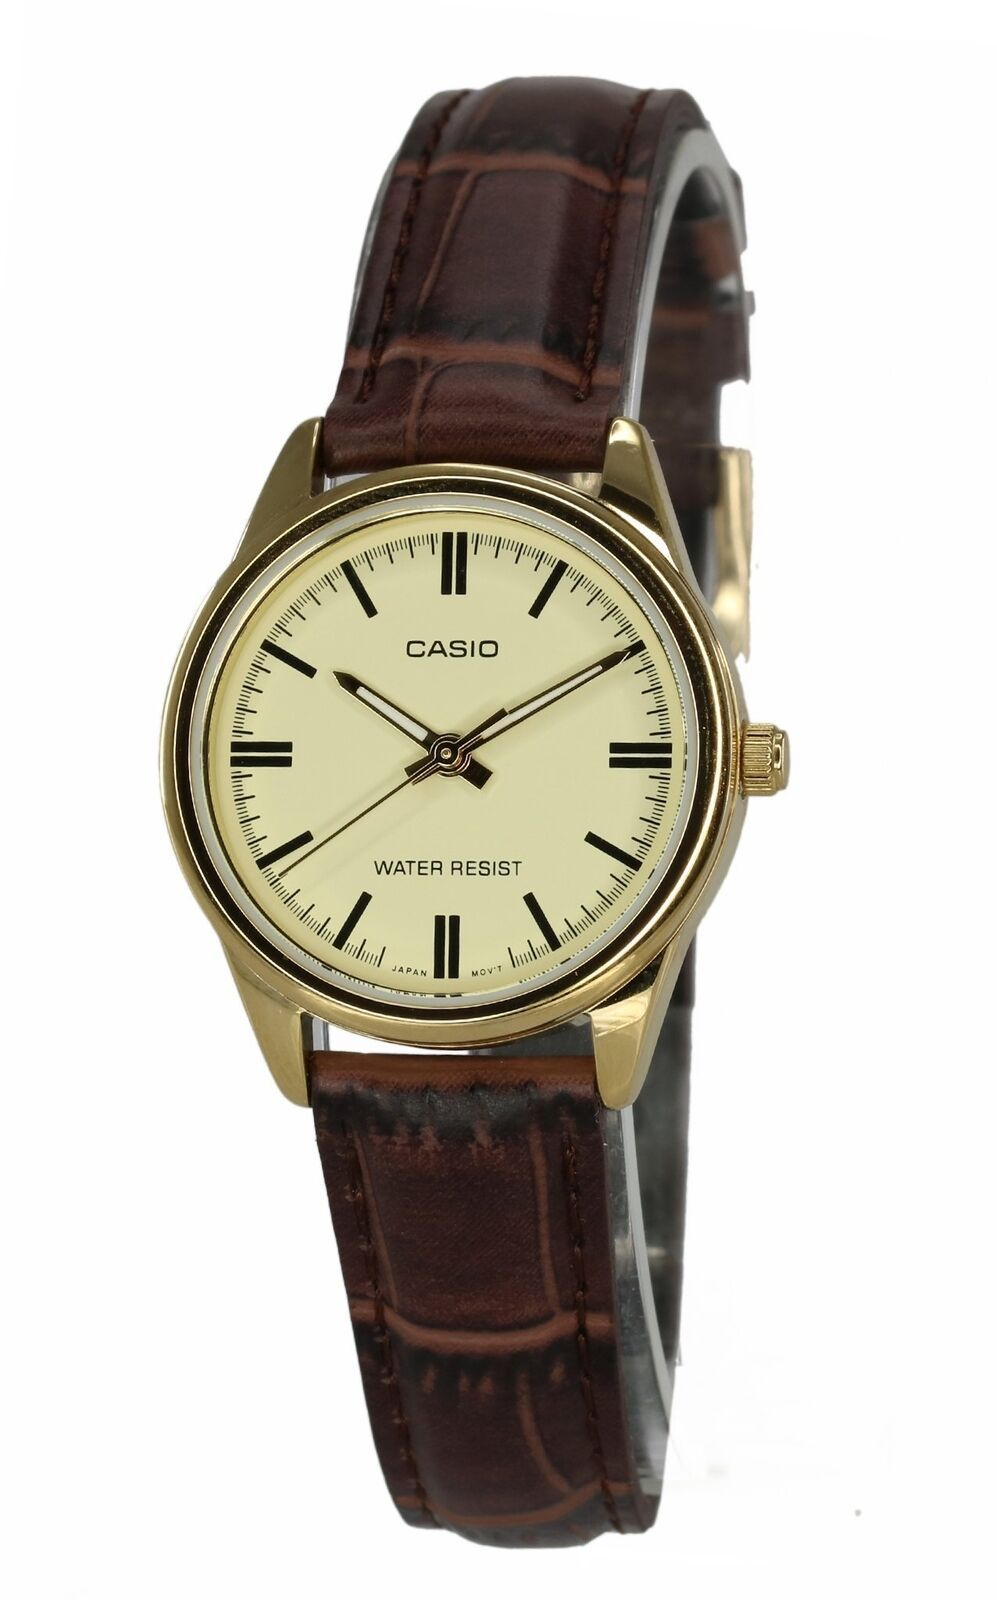

 HYBRID AI FLATLAY GENERATOR
Found top: 3cbceacea3e18b4b496484616b71fcf2.jpg
Found bottom: 97c48ff93b12ca85753abe936b35b460.jpg
Found shoes: 4734d191ac9282558254ff811c47d5be.jpg
Found glasses: 8a138784ac56d26d20215740d76d106f.jpg
Found hat: 08f0e6a91870aec2725b510d5066babc.jpg
Found watch: 05480785069e732109695753a095707a.jpg

Using 6 items


 Generating simple light background with AI accessories...


  0%|          | 0/30 [00:00<?, ?it/s]


Background generated!

AI-Generated Background (very light & simple):


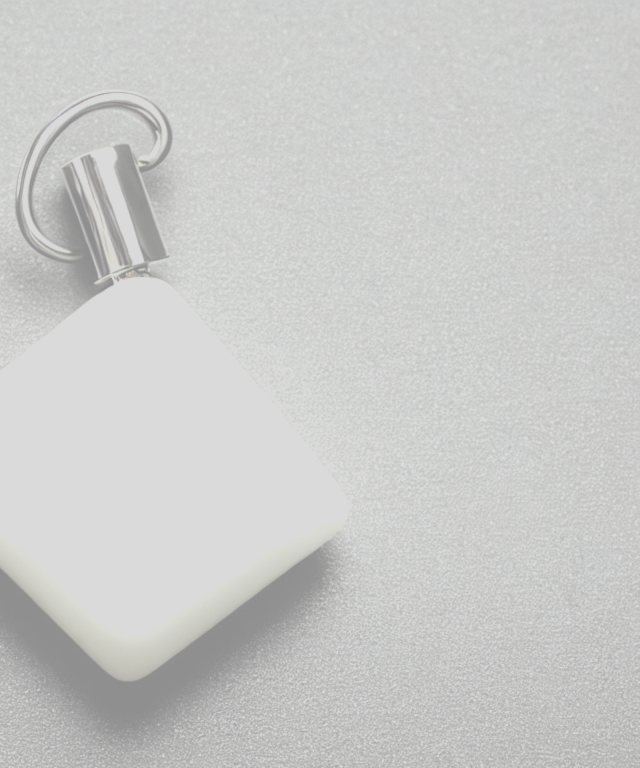


Creating flatlay composition with real images...

 Processing top...
 Removing background from 3cbceacea3e18b4b496484616b71fcf2.jpg...
  top placed successfully

 Processing bottom...
 Removing background from 97c48ff93b12ca85753abe936b35b460.jpg...
  bottom placed successfully

 Processing hat...
 Removing background from 08f0e6a91870aec2725b510d5066babc.jpg...
  hat placed successfully

 Processing glasses...
 Removing background from 8a138784ac56d26d20215740d76d106f.jpg...
  glasses placed successfully

 Processing watch...
 Removing background from 05480785069e732109695753a095707a.jpg...
  watch placed successfully

 Processing shoes...
 Removing background from 4734d191ac9282558254ff811c47d5be.jpg...
  shoes placed successfully
GENERATION COMPLETE!

Saved as: hybrid_flatlay_real_clothes.png

Final Result:


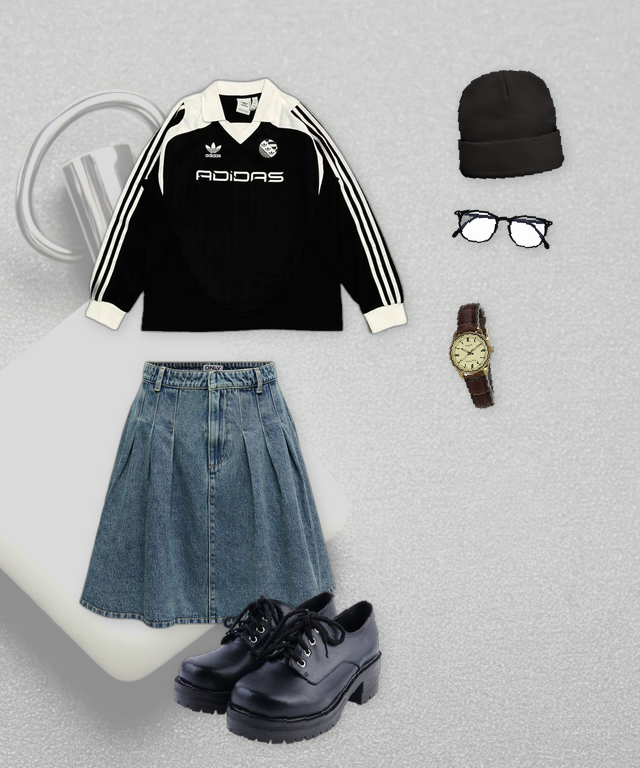


Creating flatlay composition with real images...

 Processing top...
 Removing background from 3cbceacea3e18b4b496484616b71fcf2.jpg...
  top placed successfully

 Processing bottom...
 Removing background from 97c48ff93b12ca85753abe936b35b460.jpg...
  bottom placed successfully

 Processing hat...
 Removing background from 08f0e6a91870aec2725b510d5066babc.jpg...
  hat placed successfully

 Processing glasses...
 Removing background from 8a138784ac56d26d20215740d76d106f.jpg...
  glasses placed successfully

 Processing watch...
 Removing background from 05480785069e732109695753a095707a.jpg...
  watch placed successfully

 Processing shoes...
 Removing background from 4734d191ac9282558254ff811c47d5be.jpg...
  shoes placed successfully

saved version with white background: hybrid_flatlay_white_bg.png


In [ ]:
# Generates the outfits picture

!pip install -q diffusers transformers accelerate pillow torch rembg
!pip install -q git+https://github.com/danielgatis/rembg.git

import torch
from diffusers import StableDiffusionPipeline
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
from pathlib import Path
from IPython.display import display
from rembg import remove
import random

print("Loading models...")

# Load Stable Diffusion for background generation
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

print("Models loaded!\n")


def extract_outfit_images(result):
    # Extract ALL image paths from outfit recommendation including all accessories
    outfit_images = {}

    if result.get('success') and 'breakdown' in result:
        breakdown = result['breakdown']

        # Main clothing items
        for category in ['top', 'bottom', 'shoes']:
            items = breakdown.get(category, [])
            if items and len(items) > 0:
                img_path = Path(items[0].image_path).resolve()
                if img_path.exists():
                    outfit_images[category] = str(img_path)
                    print(f"Found {category}: {img_path.name}")

        # Extract ALL accessories individually
        accessories = breakdown.get('accessories', [])
        for item in accessories:
            img_path = Path(item.image_path).resolve()
            if img_path.exists():
                # Identify accessory type from category name
                category_lower = item.category.lower()

                if 'watch' in category_lower:
                    outfit_images['watch'] = str(img_path)
                    print(f"Found watch: {img_path.name}")
                elif 'hat' in category_lower or 'cap' in category_lower or 'beanie' in category_lower:
                    outfit_images['hat'] = str(img_path)
                    print(f"Found hat: {img_path.name}")
                elif 'glass' in category_lower or 'sunglass' in category_lower:
                    outfit_images['glasses'] = str(img_path)
                    print(f"Found glasses: {img_path.name}")
                elif 'bag' in category_lower or 'purse' in category_lower:
                    outfit_images['bag'] = str(img_path)
                    print(f"Found bag: {img_path.name}")
                else:
                    # Generic accessory
                    if 'accessory1' not in outfit_images:
                        outfit_images['accessory1'] = str(img_path)
                        print(f"Found accessory: {img_path.name}")
                    elif 'accessory2' not in outfit_images:
                        outfit_images['accessory2'] = str(img_path)
                        print(f"Found accessory 2: {img_path.name}")

    return outfit_images

# GENERATE AI BACKGROUND WITH ACCESSORIES
def generate_pinterest_background_with_accessories():
    # Generate very light, simple background

    print("\n Generating simple light background with AI accessories...")

    prompt = (
        "minimal clean white background, extremely light and bright, "
        "small luxury perfume bottle in corner, tiny elegant accessories, "
        "pure white surface, barely visible subtle texture, "
        "very bright studio lighting, ultra clean, airy, "
        "almost pure white, high key photography, overexposed bright, "
        "minimalist luxury, simple elegant"
    )

    negative_prompt = (
        "clothing, shirts, pants, shoes, person, model, cluttered, busy, crowded, "
        "text, watermark, low quality, dark, harsh lighting, heavy shadows, grey, dim, "
        "messy, chaotic, complex, detailed background, colorful, patterns"
    )

    background = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=30,
        guidance_scale=7.0,
        height=768,
        width=640
    ).images[0]

    enhancer = ImageEnhance.Brightness(background)
    background = enhancer.enhance(1.7)

    enhancer = ImageEnhance.Contrast(background)
    background = enhancer.enhance(0.3)

    background = background.filter(ImageFilter.GaussianBlur(radius=0.5))

    return background

# REMOVE BACKGROUNDS FROM CLOTHING
def remove_background(image_path):
    print(f" Removing background from {Path(image_path).name}...")

    input_image = Image.open(image_path).convert('RGB')

    # Use rembg AI background removal
    output_image = remove(input_image)

    return output_image

# ADD SHADOWS
def create_shadow(image, offset=(10, 10), blur=15, opacity=0.3):
    shadow = Image.new('RGBA', image.size, (0, 0, 0, 0))

    if image.mode == 'RGBA':
        alpha = image.split()[3]
    else:
        alpha = Image.new('L', image.size, 255)

    shadow_alpha = alpha.point(lambda p: int(p * opacity))
    shadow.putalpha(shadow_alpha)

    shadow = shadow.filter(ImageFilter.GaussianBlur(blur))

    return shadow


# COMPOSITE EVERYTHING
def create_hybrid_flatlay(outfit_images, background):

    print("\nCreating flatlay composition with real images...")

    canvas = background.convert('RGBA')
    canvas_width, canvas_height = canvas.size

    # Shift everything to the left to prevent right-side cropping
    center_x = canvas_width // 2 - 50

    # Main outfit centered, accessories positioned to avoid cropping
    positions = {
        # MAIN OUTFIT
        'top': {
            'pos': (center_x - 200, 20),
            'rotation': 0,
            'size': 400
        },
        'bottom': {
            'pos': (center_x - 205, 290),
            'rotation': 0,
            'size': 410
        },
        'shoes': {
            'pos': (center_x - 125, 530),
            'rotation': -3,
            'size': 250
        },

        # RIGHT SIDE ACCESSORIES
        'hat': {
            'pos': (center_x + 160, 50),
            'rotation': 8,
            'size': 140
        },
        'glasses': {
            'pos': (center_x + 165, 180),
            'rotation': -5,
            'size': 120
        },
        'watch': {
            'pos': (center_x + 160, 290),
            'rotation': 10,
            'size': 115
        },

    }

    # Process items in order
    order = ['top', 'bottom', 'hat', 'glasses', 'watch', 'shoes']

    for category in order:
        if category not in outfit_images:
            continue

        config = positions.get(category)
        if not config:
            continue

        try:
            print(f"\n Processing {category}...")

            # Remove background
            item_img = remove_background(outfit_images[category])

            # Resize
            item_img.thumbnail((config['size'], config['size']), Image.Resampling.LANCZOS)

            # Rotate
            if category in ['top', 'bottom']:
                angle = config['rotation']
            else:
                angle = config['rotation'] + random.randint(-2, 2)

            item_img = item_img.rotate(angle, expand=True, fillcolor=(0,0,0,0))

            # Create very subtle shadow
            shadow = create_shadow(item_img, offset=(3, 3), blur=6, opacity=0.15)

            # Position - minimal randomness
            x, y = config['pos']
            if category not in ['top', 'bottom']:
                x += random.randint(-3, 3)
                y += random.randint(-3, 3)

            # Paste shadow first
            shadow_x = x + 3
            shadow_y = y + 3
            canvas.paste(shadow, (shadow_x, shadow_y), shadow)

            # Paste item
            canvas.paste(item_img, (x, y), item_img)

            print(f"  {category} placed successfully")

        except Exception as e:
            print(f" Error with {category}: {e}")

    return canvas.convert('RGB')

# MAIN FUNCTION
def generate_hybrid_flatlay(result):
    print(" HYBRID AI FLATLAY GENERATOR")

    # Extract outfit images
    outfit_images = extract_outfit_images(result)

    if not outfit_images:
        print("No outfit images found")
        return None

    print(f"\nUsing {len(outfit_images)} items\n")

    # Generate AI background with accessories
    background = generate_pinterest_background_with_accessories()

    print("\nBackground generated!")
    print("\nAI-Generated Background (very light & simple):")
    display(background)

    # Composite real images
    final_image = create_hybrid_flatlay(outfit_images, background)

    # Save
    output_path = "hybrid_flatlay_real_clothes.png"
    final_image.save(output_path)

    print("GENERATION COMPLETE!")
    print(f"\nSaved as: {output_path}\n")

    print("Final Result:")
    display(final_image)

    white_bg = Image.new('RGB', final_image.size, (255, 255, 255))
    final_no_bg = create_hybrid_flatlay(outfit_images, white_bg)
    final_no_bg.save("hybrid_flatlay_white_bg.png")

    print("\nsaved version with white background: hybrid_flatlay_white_bg.png")

    return final_image


result = show_outfit_recommendation(include_accessories=True)
generated = generate_hybrid_flatlay(result)